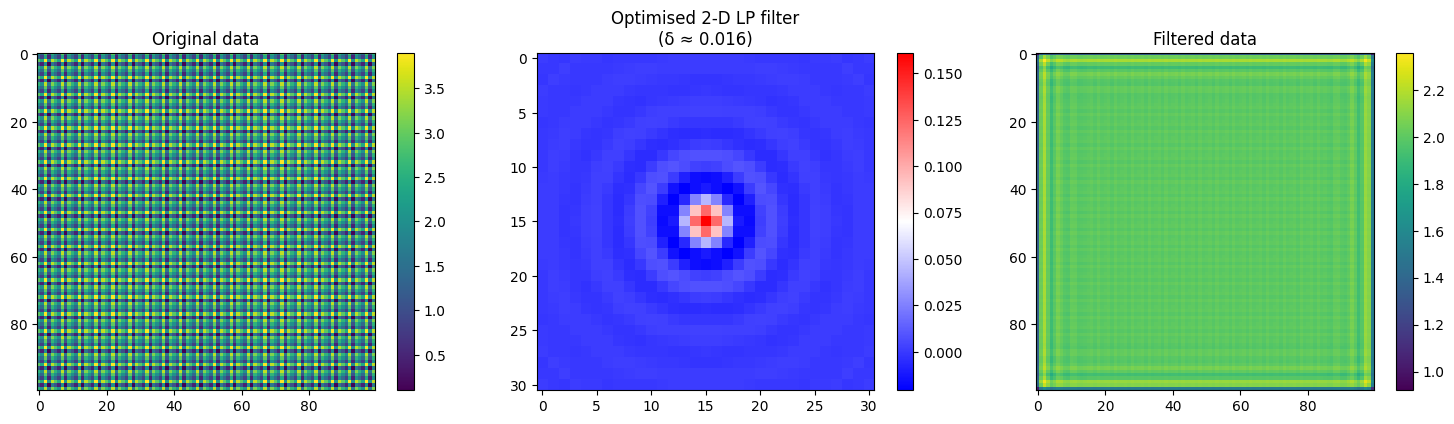

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.signal import fftconvolve

# ---------- 0. входные данные ------------------------------------------------
data = np.array([])
o_x = 100
o_y = 100
w = 0.4
x_vals = np.arange(o_x)
y_vals = np.arange(o_y)
X, Y = np.meshgrid(x_vals, y_vals, indexing='xy')
data = 2 + np.sin(np.pi + X * w * np.pi * 2) + np.sin(np.pi + Y * w * np.pi * 2)

# ---------- 1. параметры фильтра ---------------------------------------------
N = 31                   # размер ядра (нечётный ⇒ нулевая фаза)
cutoff = 0.2             # граница полосы пропускания (0–0.5)
transition = 0.05        # ширина переходной зоны
G = 81                 # размер сетки, на которой будем оптимизировать АЧХ

# ---------- 2. создание матрицы ДПФ ------------------------------------------
# координаты частотной сетки
u = (np.arange(G) - G // 2) / G
U, V = np.meshgrid(u, u, indexing="ij")
R = np.sqrt(U**2 + V**2)

pass_mask = R <= cutoff                 # точки полосы пропускания
stop_mask = R >= cutoff + transition    # точки полосы задерживания

# координаты импульсной характеристики (с центром в 0,0)
coords = np.array([(i - N // 2, j - N // 2) for i in range(N) for j in range(N)])

def build_A(mask):

    rows = []
    idx = np.where(mask)
    for k, l in zip(idx[0], idx[1]):
        du, dv = U[k, l], V[k, l]
        rows.append(np.real(np.exp(-2j * np.pi * (du * coords[:, 0] + dv * coords[:, 1]))))
    return np.asarray(rows)

A_pass = build_A(pass_mask)   # H(k) для passband
A_stop = build_A(stop_mask)   # H(k) для stopband

M = N * N                     # число коэффициентов фильтра
# вектор переменных: [h_0 … h_{M-1}, δ]
c = np.zeros(M + 1)
c[-1] = 1                     # цель → минимизируем δ (макс. рябь)

# --- равенство: нормировка DC‑усиления ---------------------------
A_eq = np.zeros((1, M + 1))
A_eq[0, :M] = 1
b_eq = np.array([1.0])        # Σ h[i,j] = 1  ⇒  H(0) = 1

# --- неравенства (Chebyshev‑критерий) ----------------------------
A_ub, b_ub = [], []

# полоса пропускания:  1‑δ ≤ H ≤ 1+δ  ⇒  ±H − δ ≤ ±1
A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
b_ub += [ np.ones(A_pass.shape[0]) ]
A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
b_ub += [-np.ones(A_pass.shape[0])]

# полоса задерживания: |H| ≤ δ  ⇒  ±H − δ ≤ 0
A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
b_ub += [ np.zeros(A_stop.shape[0]) ]
A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
b_ub += [ np.zeros(A_stop.shape[0]) ]

A_ub = np.vstack(A_ub)
b_ub = np.hstack(b_ub)

bounds = [(-1, 1)] * M + [(0, None)]   # h[i,j] ограничим по модулю 1, δ ≥ 0

res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds=bounds, method="highs")

h = res.x[:M].reshape(N, N)

# --- форсируем полную симметрию ядра (нулевая фаза) -------------
for i in range(N):
    for j in range(N):
        i2, j2 = N - 1 - i, N - 1 - j
        mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4
        h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

#h_sym = (h + np.flipud(h) + np.fliplr(h) + np.flipud(np.fliplr(h))) / 4
#h = h_sym
# ---------- 3. фильтрация данных --------------------------------------------
filtered_fft = fftconvolve(data, h, mode="same")

# ---------- 4. графики --------------------------------------------------------
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(data, cmap="viridis")
plt.title("Original data")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(h, cmap="bwr")
plt.title("Optimised 2‑D LP filter\n(δ ≈ {:.3f})".format(res.x[-1]))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(filtered_fft, cmap="viridis")
plt.title("Filtered data")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# 3. Округляем до 4 знаков после запятой
h_rounded = np.round(h, 4)

# 4. Сохраняем в TXT файл
np.savetxt("impulse_response.txt", h_rounded, fmt="%.4f")

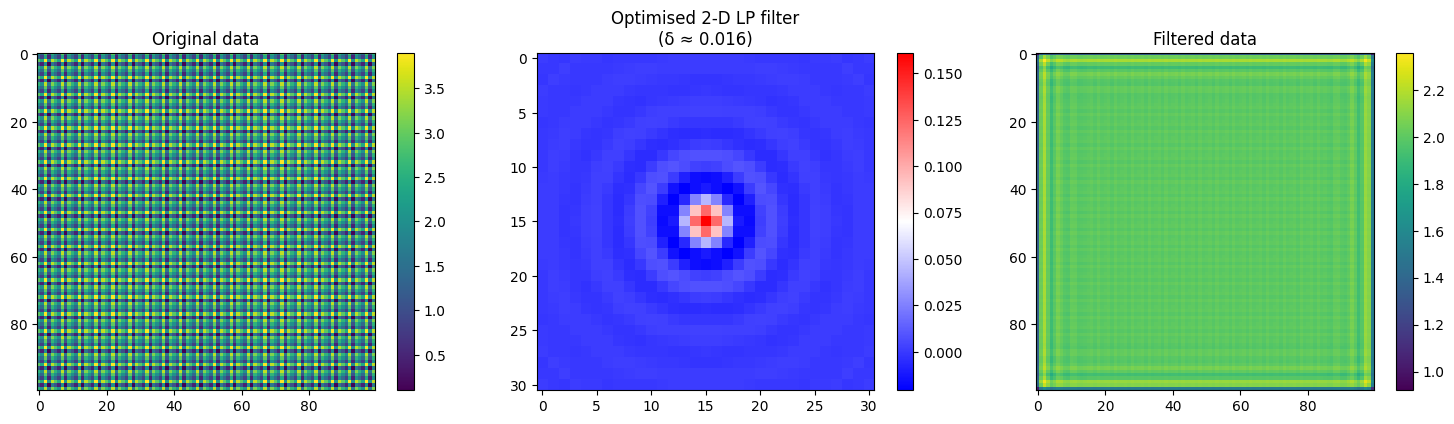

In [ ]:
# ---------- 0. входные данные ------------------------------------------------
data = np.array([])
o_x = 100
o_y = 100
w = 0.4
x_vals = np.arange(o_x)
y_vals = np.arange(o_y)
X, Y = np.meshgrid(x_vals, y_vals, indexing='xy')
data = 2 + np.sin(np.pi + X * w * np.pi * 2) + np.sin(np.pi + Y * w * np.pi * 2)

filtered_fft = fftconvolve(data, h, mode="same")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(data, cmap="viridis")
plt.title("Original data")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(h, cmap="bwr")
plt.title("Optimised 2‑D LP filter\n(δ ≈ {:.3f})".format(res.x[-1]))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(filtered_fft, cmap="viridis")
plt.title("Filtered data")
plt.colorbar()

plt.tight_layout()
plt.show()


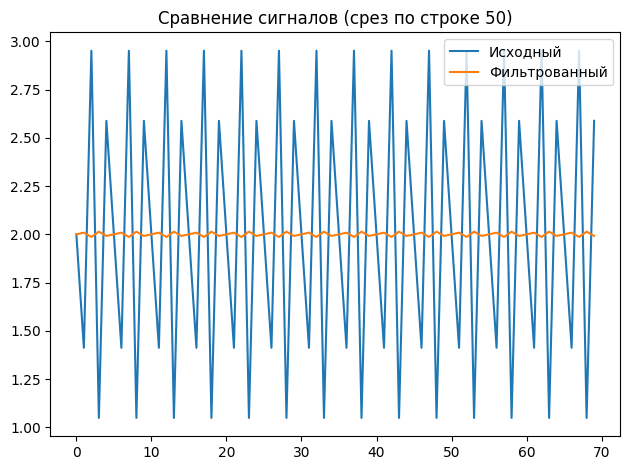

In [ ]:
N = 31
margin = N // 2  # = 15

plt.plot(data[50, margin:-margin], label='Исходный')
plt.plot(filtered_fft[50, margin:-margin], label='Фильтрованный')
plt.legend()
plt.title("Сравнение сигналов (срез по строке 50)")
plt.tight_layout()
plt.show()

In [ ]:
margin = N // 2

core_data = data[margin:-margin, margin:-margin]
core_filtered = filtered_fft[margin:-margin, margin:-margin]

signal_only = core_data - 2
residual = core_filtered - 2

abs_error = np.abs(residual)

relative_error = np.sum(abs_error) / np.sum(np.abs(signal_only)) * 100

print(f"Процент сходства: {relative_error:.2f} %")

Процент сходства: 1.45 %


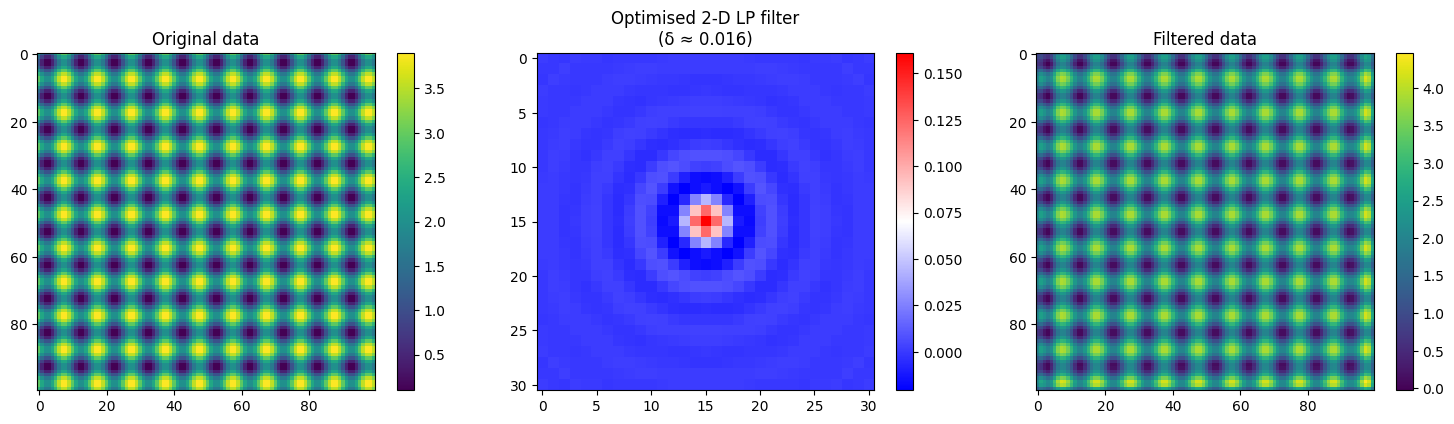

In [ ]:
# ---------- 0. входные данные ------------------------------------------------
data = np.array([])
o_x = 100
o_y = 100
w = 0.1
x_vals = np.arange(o_x)
y_vals = np.arange(o_y)
X, Y = np.meshgrid(x_vals, y_vals, indexing='xy')
data = 2 + np.sin(np.pi + X * w * np.pi * 2) + np.sin(np.pi + Y * w * np.pi * 2)

filtered_fft = fftconvolve(data, h, mode="same")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(data, cmap="viridis")
plt.title("Original data")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(h, cmap="bwr")
plt.title("Optimised 2‑D LP filter\n(δ ≈ {:.3f})".format(res.x[-1]))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(filtered_fft, cmap="viridis")
plt.title("Filtered data")
plt.colorbar()

plt.tight_layout()
plt.show()


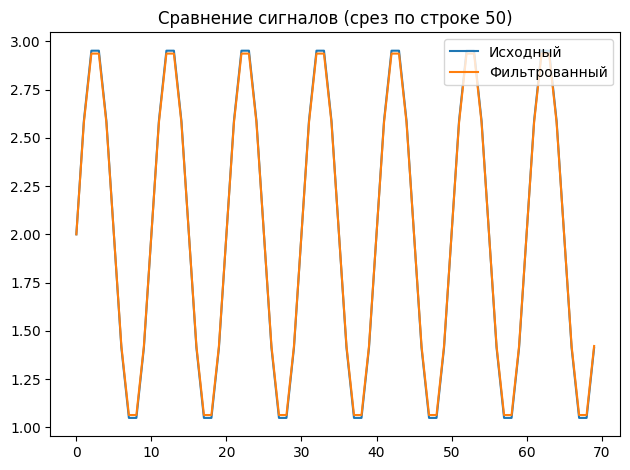

In [ ]:
N = 31
margin = N // 2  # = 15

plt.plot(data[50, margin:-margin], label='Исходный')
plt.plot(filtered_fft[50, margin:-margin], label='Фильтрованный')
plt.legend()
plt.title("Сравнение сигналов (срез по строке 50)")
plt.tight_layout()
plt.show()

In [ ]:
margin = N // 2

core_data = data[margin:-margin, margin:-margin]
core_filtered = filtered_fft[margin:-margin, margin:-margin]

signal_only = core_data - 2
residual = core_filtered - 2

abs_error = np.abs(residual)

relative_error = np.sum(abs_error) / np.sum(np.abs(signal_only)) * 100

print(f"Процент сходства: {relative_error:.2f} %")

Процент сходства: 98.43 %


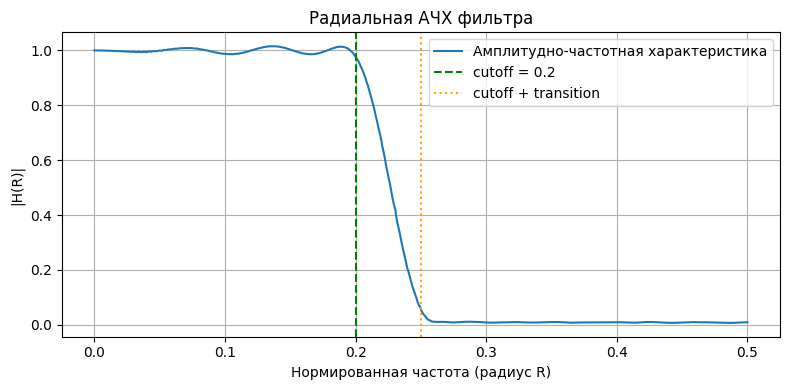

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 2D-фурье ядра с zero-padding для плотности
H = np.fft.fftshift(np.fft.fft2(h, s=(256, 256)))
H_mag = np.abs(H)

# --- создаём полярную сетку (нормированные частоты)
fsize = H.shape[0]
u = np.linspace(-0.5, 0.5, fsize)
U, V = np.meshgrid(u, u)
R = np.sqrt(U**2 + V**2)  # расстояние от центра

# --- усреднение АЧХ по кольцам одинакового радиуса
r_vals = np.linspace(0, 0.5, 500)
H_radial = np.zeros_like(r_vals)

for i, r in enumerate(r_vals):
    mask = (R >= r - 0.005) & (R <= r + 0.005)
    if np.any(mask):
        H_radial[i] = np.mean(H_mag[mask])

# --- рисуем
plt.figure(figsize=(8, 4))
plt.plot(r_vals, H_radial, label="Амплитудно-частотная характеристика")
plt.axvline(0.2, color='green', linestyle='--', label="cutoff = 0.2")
plt.axvline(0.25, color='orange', linestyle=':', label="cutoff + transition")
plt.xlabel("Нормированная частота (радиус R)")
plt.ylabel("|H(R)|")
plt.title("Радиальная АЧХ фильтра")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


--- Результаты Восстановления (Разделяемый linprog) ---
MSE: 0.01662977
PSNR: 30.99 dB
Средняя абсолютная ошибка (MAE): 1.664984
Средняя относительная ошибка: 86.9195%


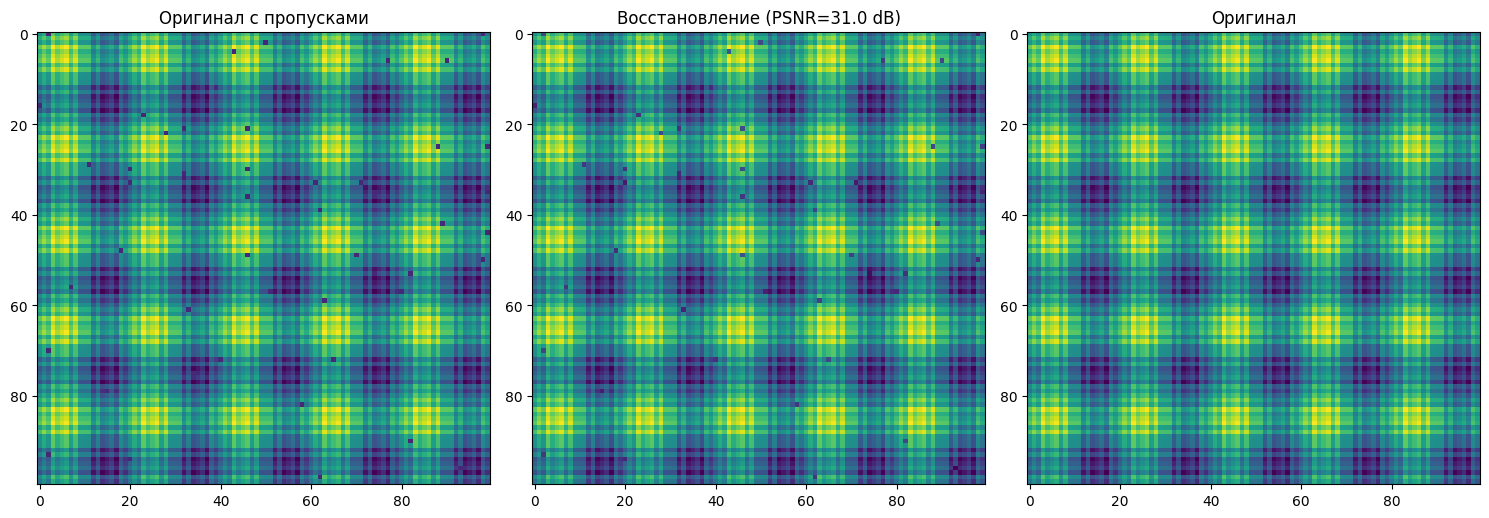

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.signal import convolve2d

# --- 1. СИНТЕЗ ФИЛЬТРА (Разделяемый 2D через 1D linprog) ---

def design_lp_filter_separable(N, cutoff, transition, G=401):
    """
    Синтез 2D КИХ-ФНЧ через синтез 1D фильтра методом linprog
    (для сохранения точности 0.1% и экономии памяти).
    """

    # --- 1. Синтез 1D КИХ-фильтра методом linprog ---

    # 1D частотная сетка
    u = (np.arange(G) - G // 2) / G

    # Координаты отсчетов фильтра (от -M до M)
    coords = np.arange(N) - N // 2

    # Маски для 1D
    pass_mask = np.abs(u) <= cutoff
    stop_mask = np.abs(u) >= cutoff + transition

    # Функция для построения 1D матрицы ограничений
    def build_A_1d(mask):
        rows = []
        idx = np.where(mask)
        for k in idx[0]:
            du = u[k]
            # Дисперсное представление ДПФ: exp(-2j*pi*du*coords)
            rows.append(np.real(np.exp(-2j * np.pi * du * coords)))
        return np.vstack(rows)

    A_pass_1d = build_A_1d(pass_mask)
    A_stop_1d = build_A_1d(stop_mask)

    M_1d = N
    c_1d = np.zeros(M_1d + 1); c_1d[-1] = 1.0 # Минимизация максимальной ошибки
    A_eq_1d = np.zeros((1, M_1d + 1)); A_eq_1d[0, :M_1d] = 1.0; b_eq_1d = [1.0] # Условие H(0)=1

    # Ограничения для полос пропускания и непропускания
    A_ub_1d = [np.hstack([A_pass_1d, -np.ones((A_pass_1d.shape[0], 1))]),
               np.hstack([-A_pass_1d, -np.ones((A_pass_1d.shape[0], 1))]),
               np.hstack([A_stop_1d, -np.ones((A_stop_1d.shape[0], 1))]),
               np.hstack([-A_stop_1d, -np.ones((A_stop_1d.shape[0], 1))])]
    b_ub_1d = np.hstack([np.ones(A_pass_1d.shape[0]), -np.ones(A_pass_1d.shape[0]),
                         np.zeros(A_stop_1d.shape[0]), np.zeros(A_stop_1d.shape[0])])

    # Выполнение 1D оптимизации
    res = linprog(c_1d, np.vstack(A_ub_1d), b_ub_1d, A_eq_1d, b_eq_1d,
                  bounds=[(-1,1)]*M_1d + [(0,None)], method="highs")

    h_1d = res.x[:M_1d]

    # Принудительная симметрия (для линейной фазы)
    h_1d = (h_1d + h_1d[::-1]) / 2.0

    # --- 2. Формирование 2D фильтра ---
    # 2D фильтр как произведение двух 1D фильтров
    h_2d = np.outer(h_1d, h_1d)

    # Нормализация 2D фильтра
    h_2d /= np.sum(h_2d)

    return h_2d

# --- 2. ФУНКЦИЯ ВОССТАНОВЛЕНИЯ ОДНОГО ШАГА (Формула 3) ---

def recover_component(data_missing_band, h):
    # Используем 'wrap' для учета краевых эффектов (периодическое расширение).
    return convolve2d(data_missing_band, h, mode='same', boundary='wrap')

# --- 3. ПОДГОТОВКА ДАННЫХ ---

o_x = o_y = 100
w_low = 0.05
w_high = 0.4
X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y))

# Исходный сигнал: постоянная + НЧ-синус + ВЧ-синус
data_low = 2 + np.sin(2*np.pi*w_low*X) + np.sin(2*np.pi*w_low*Y)
data_high = 0.5 * (np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y))
data_original = data_low + data_high

np.random.seed(1)
mask_missing = np.random.rand(o_x, o_y) < 0.005 # Пропуски 0.5%
data_missing = data_original.copy()
data_missing[mask_missing] = 0.0 # Обнуляем пропуски для алгоритма
data_orig_missing = data_missing.copy()
true_values = data_original[mask_missing]

# --- 4. СИНТЕЗ ФИЛЬТРОВ И ПАРАМЕТРЫ ---

N_filt = 21
M = N_filt // 2

# Параметры оптимизации для linprog: G должно быть большим для точности 0.1%
G_grid = 1001
transition_narrow = 0.01

# Этап 1: ФНЧ для разделения
# Полоса 0.2, переход 0.05
h_sep = design_lp_filter_separable(N_filt, cutoff=0.20, transition=0.05, G=G_grid)

# Этап 2: ФНЧ для восстановления НЧ. Полоса шире, чем w_low=0.05.
# Полоса 0.1, переход 0.01
h_lp_restore = design_lp_filter_separable(N_filt, cutoff=0.10, transition=transition_narrow, G=G_grid)

# Этап 3: ФВЧ для восстановления ВЧ.
# Сначала синтезируем ФНЧ с полосой шире, чем w_high=0.4.
# Полоса 0.45, переход 0.01
h_lp_for_hp = design_lp_filter_separable(N_filt, cutoff=0.22, transition=transition_narrow, G=G_grid)
# ФВЧ: I - H_LPF
I_impulse = np.zeros((N_filt, N_filt)); I_impulse[M, M] = 1.0
h_hp_restore = I_impulse - h_lp_for_hp

# --- 5. ВОССТАНОВЛЕНИЕ (Этапы 1-4) ---

# Этап 1: Разделение пропущенного сигнала
low_sep_missing = recover_component(data_missing, h_sep)
high_sep_missing = data_missing - low_sep_missing

# Этап 2: Восстановление НЧ-составляющей (x^H)
low_rest = recover_component(low_sep_missing, h_lp_restore)

# Этап 3: Восстановление ВЧ-составляющей (x^B)
high_rest = recover_component(high_sep_missing, h_hp_restore)

# [cite_start]Этап 4: Сумма [cite: 27]
proposed = low_rest + high_rest
recovered_values = proposed[mask_missing]

# --- 6. МЕТРИКА И ВИЗУАЛИЗАЦИЯ ---

current_reconstruction = data_missing.copy()
current_reconstruction[mask_missing] = recovered_values

mse = np.mean((current_reconstruction - data_original)**2)
psnr = 10 * np.log10(np.max(data_original)**2 / mse)

# Средняя абсолютная ошибка
absolute_errors = np.abs(recovered_values - true_values)
mean_abs_error = np.mean(absolute_errors)

print(f"\n--- Результаты Восстановления (Разделяемый linprog) ---")
print(f"MSE: {mse:.8f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"Средняя абсолютная ошибка (MAE): {mean_abs_error:.6f}")
print(f"Средняя относительная ошибка: {np.mean(np.abs(recovered_values - true_values) / true_values) * 100:.4f}%")


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title("Оригинал с пропусками"); plt.imshow(data_orig_missing, cmap='viridis');
plt.subplot(1, 3, 2); plt.title(f"Восстановление (PSNR={psnr:.1f} dB)"); plt.imshow(current_reconstruction, cmap='viridis');
plt.subplot(1, 3, 3); plt.title("Оригинал"); plt.imshow(data_original, cmap='viridis');
plt.tight_layout()
plt.show()

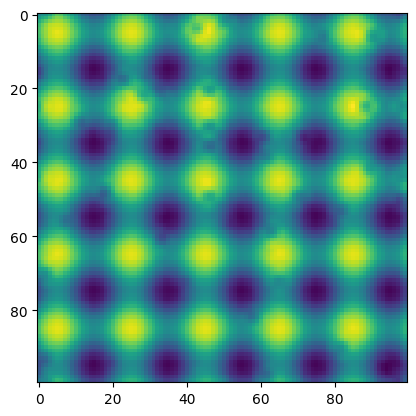

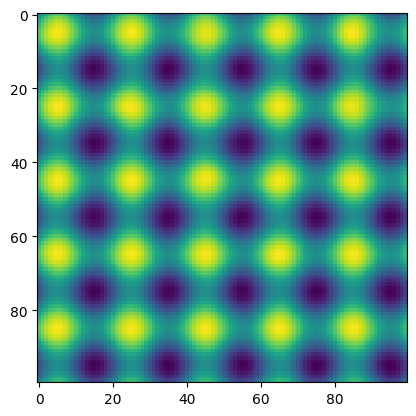

In [ ]:
plt.imshow(low_sep_missing)
plt.show()
plt.imshow(low_rest)

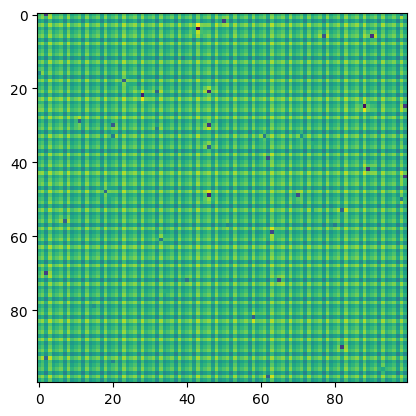

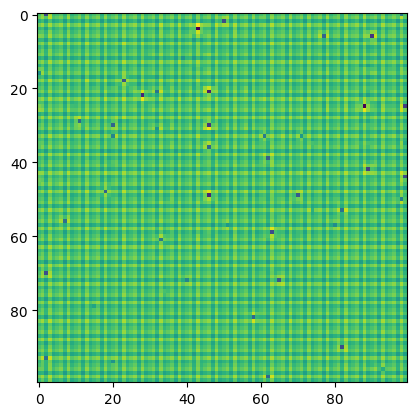

In [ ]:
plt.imshow(high_sep_missing)
plt.show()
plt.imshow(high_rest)

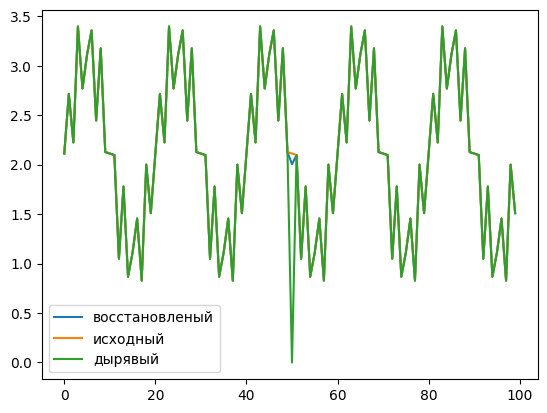

In [ ]:
L = 2
plt.plot(current_reconstruction[L],label='восстановленый')
plt.plot(data_original[L],label='исходный')
plt.plot(data_orig_missing[L],label='дырявый')
plt.legend()
plt.show()

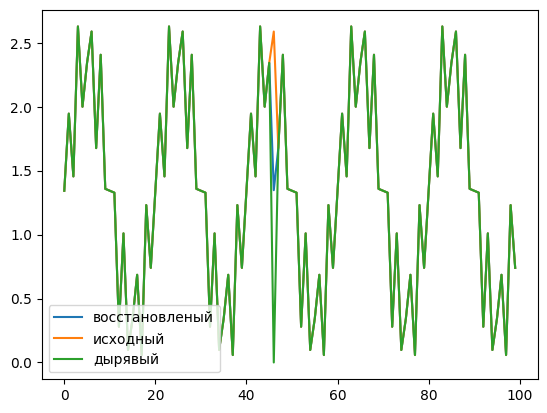

In [ ]:
L =36
plt.plot(current_reconstruction[L],label='восстановленый')
plt.plot(data_original[L],label='исходный')
plt.plot(data_orig_missing[L],label='дырявый')
plt.legend()
plt.show()

тест


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.signal import convolve2d

# --- 1. СИНТЕЗ ФИЛЬТРА (Разделяемый 2D через 1D linprog) ---

def design_lp_filter_2d(N, cutoff, transition, G=81):
    """
    2D КИХ-ФНЧ методом линейного программирования (минимакс, Chebyshev).
    Радиа́льная полоса пропускания: R <= cutoff
    Полоса задерживания:          R >= cutoff + transition
    """
    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R <= cutoff
    stop_mask = R >= cutoff + transition

    coords = np.array([(i - N // 2, j - N // 2) for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(-2j * np.pi * (du * coords[:, 0] + dv * coords[:, 1]))))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1); c[-1] = 1.0

    # H(0) = 1  => сумма коэффициентов = 1
    A_eq = np.zeros((1, M + 1))
    A_eq[0, :M] = 1.0
    b_eq = np.array([1.0])

    A_ub, b_ub = [], []

    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]

    res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # Форсируем полную симметрию (нулевая фаза)
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]   # фильтр и величина ряби δ

def design_hp_filter_2d(N, cutoff, transition, G=81):
    """
    2D КИХ-ФВЧ через linprog.
    passband: R >= cutoff
    stopband: R <= cutoff - transition
    """
    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R >= cutoff
    stop_mask = R <= cutoff - transition

    coords = np.array([(i - N // 2, j - N // 2) for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(-2j * np.pi * (du * coords[:, 0] + dv * coords[:, 1]))))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1); c[-1] = 1.0

    A_eq = np.zeros((1, M + 1))
    # Для HPF DC-усиление должно быть ≈0: Σh = 0
    # (иначе низкая частота не подавится)
    # Поэтому просто не трогаем последний столбец δ:
    A_eq[0, :M] = 0.0
    b_eq = np.array([0.0])

    A_ub, b_ub = [], []

    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]

    res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # симметрия
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]

# --- 3. ПОДГОТОВКА ДАННЫХ ---

o_x = o_y = 100
w_low = 0.05
w_high = 0.4
X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y))

# Исходный сигнал: постоянная + НЧ-синус + ВЧ-синус
data_low = 2 + np.sin(2*np.pi*w_low*X) + np.sin(2*np.pi*w_low*Y)
data_high = 0.5 * (np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y))
data_original = data_low + data_high

np.random.seed(1)
mask_missing = np.random.rand(o_x, o_y) < 0.0005 # Пропуски 0.5%
data_missing = data_original.copy()
data_missing[mask_missing] = 0.0 # Обнуляем пропуски для алгоритма
data_orig_missing = data_missing.copy()
true_values = data_original[mask_missing]

In [ ]:
def recover_component_local(data_band, h, mask_missing):

    H, W = data_band.shape
    N = h.shape[0]
    M = N // 2
    h0 = h[M, M]
    denom = 1.0 - h0

    restored = data_band.copy()

    missing_idxs = np.argwhere(mask_missing)
    for i0, j0 in missing_idxs:
        s = 0.0
        for di in range(-M, M+1):
            for dj in range(-M, M+1):
                if di == 0 and dj == 0:
                    continue
                ii = (i0 - di) % H   # 'wrap' граница, как в convolve2d
                jj = (j0 - dj) % W
                s += h[M+di, M+dj] * data_band[ii, jj]

        restored[i0, j0] = s / denom

    return restored


In [ ]:
# --- 4. СИНТЕЗ ФИЛЬТРОВ И ПАРАМЕТРЫ ---

N_filt = 21  # лучше взять 31 или 41, чем 21

transition_narrow = 0.05   # можно взять чуть шире, если LP не сходится

# ФНЧ разделения (между НЧ=0.05 и ВЧ=0.4 сделаем границу около 0.2)
h_sep, delta_sep = design_lp_filter_2d(N_filt, cutoff=0.20,
                                       transition=0.05, G=81)
print('разделяющий ситезирован')

h_lp_restore, delta_lp = design_lp_filter_2d(N_filt, cutoff=0.30,
                                             transition=transition_narrow, G=81)
print('нижний синтезирован')


разделяющий ситезирован
нижний синтезирован


In [ ]:
# ФВЧ восстановления ВЧ — граница около 0.3 (выше 0.2, ниже 0.4)
h_hp_restore, delta_hp = design_hp_filter_2d(N_filt, cutoff=0.15,
                                             transition=transition_narrow, G=81)

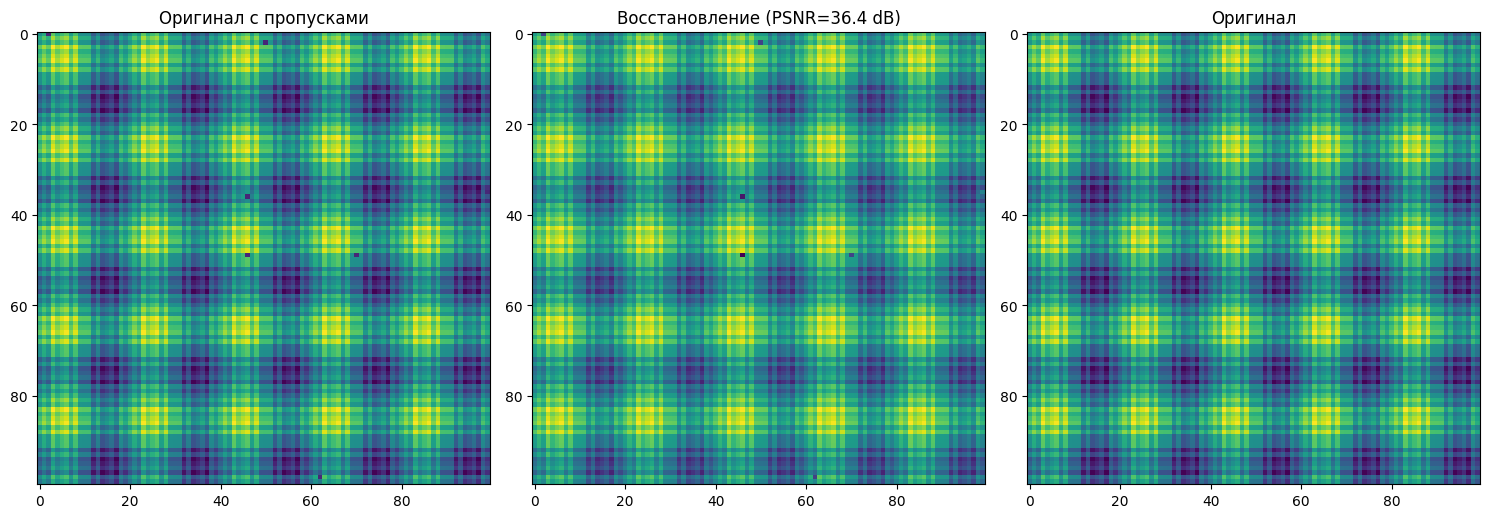

In [ ]:
# --- 5. ВОССТАНОВЛЕНИЕ (Этапы 1-4) ---

# Этап 1: разделение (как было)
low_sep_missing  = convolve2d(data_missing, h_sep, mode='same', boundary='wrap')
high_sep_missing = data_missing - low_sep_missing

# Этап 2: восстановление НЧ только в маске пропусков
low_rest = low_sep_missing.copy()
low_rest = recover_component_local(low_rest, h_lp_restore, mask_missing)

# Этап 3: восстановление ВЧ только в маске пропусков
high_rest = high_sep_missing.copy()
high_rest = recover_component_local(high_rest, h_hp_restore, mask_missing)

# Этап 4: сложение
proposed = low_rest + high_rest
current_reconstruction = data_missing.copy()
current_reconstruction[mask_missing] = proposed[mask_missing]

mse = np.mean((current_reconstruction - data_original)**2)
psnr = 10 * np.log10(np.max(data_original)**2 / mse)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title("Оригинал с пропусками"); plt.imshow(data_orig_missing, cmap='viridis');
plt.subplot(1, 3, 2); plt.title(f"Восстановление (PSNR={psnr:.1f} dB)"); plt.imshow(current_reconstruction, cmap='viridis');
plt.subplot(1, 3, 3); plt.title("Оригинал"); plt.imshow(data_original, cmap='viridis');
plt.tight_layout()
plt.show()

In [ ]:
low_sep_missing_data  = convolve2d(data_original, h_sep, mode='same', boundary='wrap')

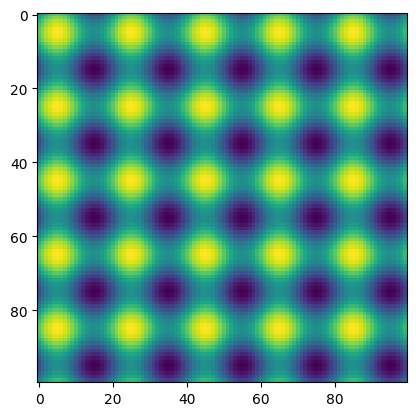

In [ ]:
plt.imshow(low_sep_missing_data)

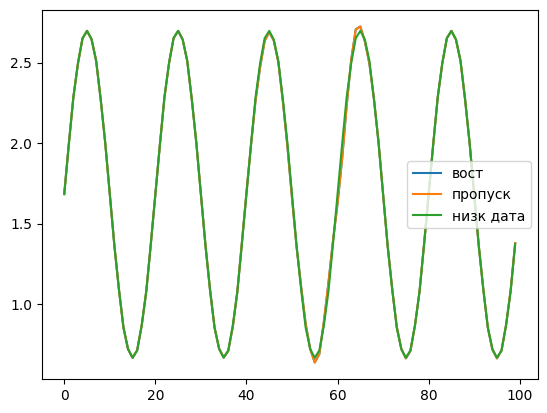

In [ ]:
N = 31
plt.plot(low_rest[N],label='вост')
plt.plot(low_sep_missing[N],label='пропуск')
plt.plot(low_sep_missing_data[N],label='низк дата')
plt.legend()
plt.show()

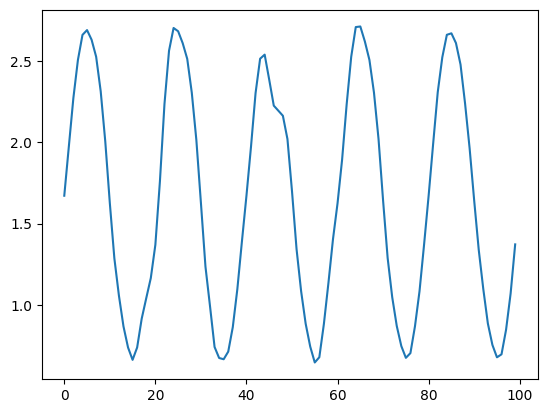

In [ ]:
plt.plot(low_rest[N],label='вост')

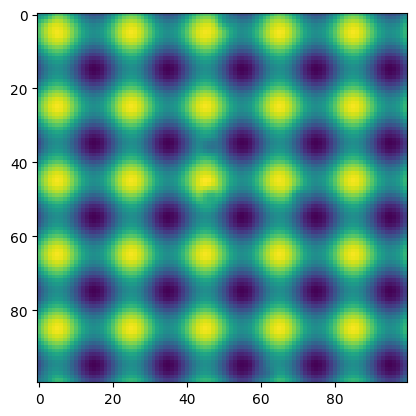

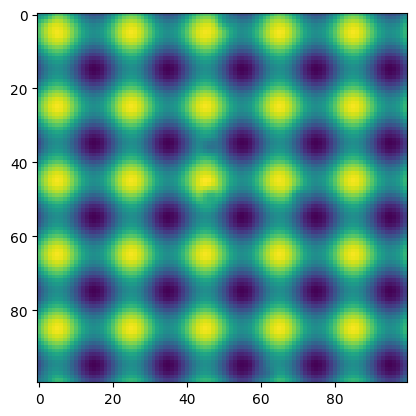

In [ ]:
plt.imshow(low_sep_missing)
plt.show()
plt.imshow(low_rest)

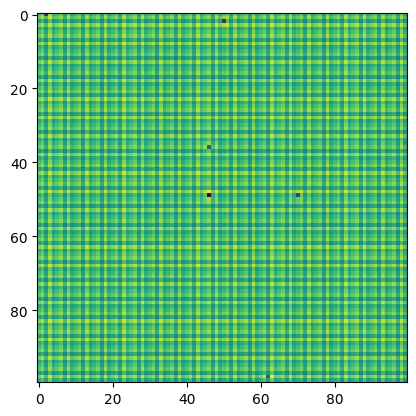

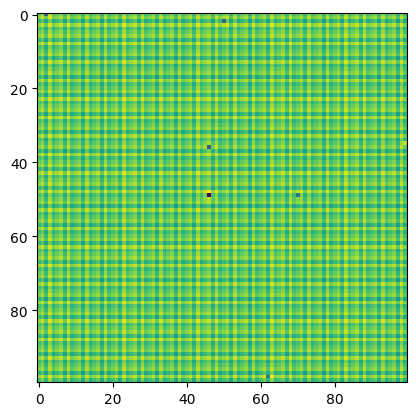

In [ ]:
plt.imshow(high_sep_missing)
plt.show()
plt.imshow(high_rest)

In [ ]:
def plot_2d_freq_response(h, title="", n_fft=1024):
    H = np.fft.fftshift(np.fft.fft2(h, (n_fft, n_fft)))
    mag = np.abs(H)

    plt.figure(figsize=(6,5))
    plt.imshow(mag, cmap='inferno')
    plt.colorbar()
    plt.title(title)
    plt.show()


In [ ]:
plot_2d_freq_response(h_sep, "H_sep")
plot_2d_freq_response(h_lp_restore, "H_lp_restore")
plot_2d_freq_response(h_hp_restore, "H_hp_restore")


NameError: name 'plot_2d_freq_response' is not defined

тест 2

ФНЧ разделения: δ ≈ 0.0002
ФНЧ восстановления НЧ: δ ≈ 0.0002
ФНЧ для построения ФВЧ: δ ≈ 0.0002


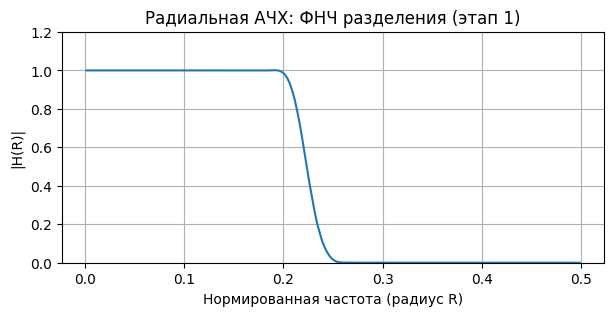

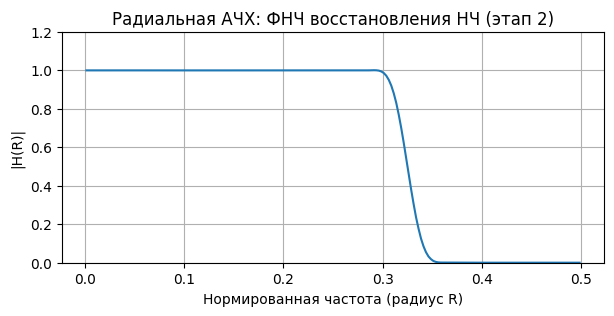

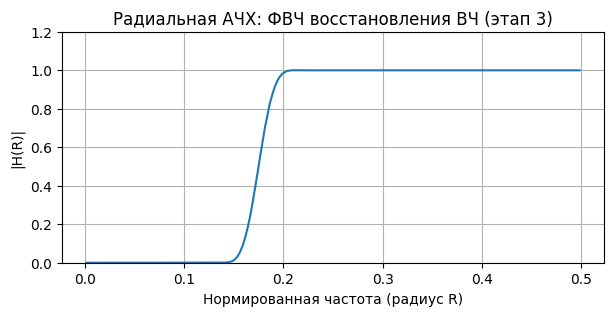


--- Результаты восстановления (N=61, 2D linprog) ---
MSE:  0.02246669
PSNR: 29.68 dB
MAE:  1.906880
Средняя относительная: 100.014 %


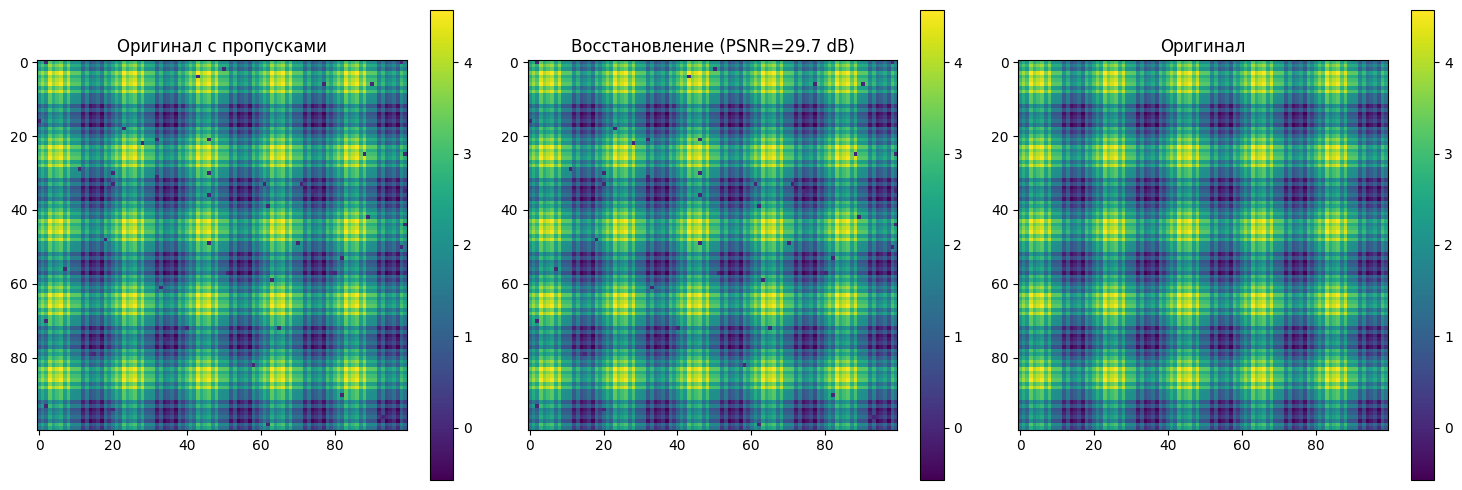

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.signal import convolve2d

# ------------------------------------------------------------
# 1. СИНТЕЗ 2D ФНЧ через linprog (как в методе)
# ------------------------------------------------------------

def design_lp_filter_2d(N, cutoff, transition, G=81):
    """
    2D КИХ-ФНЧ методом линейного программирования (Chebyshev).
    Нормированная частота по радиусу R ∈ [0, 0.5].

    passband: R <= cutoff
    stopband: R >= cutoff + transition
    """
    assert N % 2 == 1, "N должно быть нечётным"
    # сетка частот
    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R <= cutoff
    stop_mask = R >= cutoff + transition

    # координаты импульсной характеристики
    coords = np.array([(i - N // 2, j - N // 2)
                       for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(-2j * np.pi *
                                       (du * coords[:, 0] + dv * coords[:, 1]))))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1)
    c[-1] = 1.0        # минимизируем δ

    # H(0) = 1  => сумма коэффициентов = 1
    A_eq = np.zeros((1, M + 1))
    A_eq[0, :M] = 1.0
    b_eq = np.array([1.0])

    A_ub, b_ub = [], []

    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]

    res = linprog(c, A_ub, b_ub, A_eq, b_eq,
                  bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # принудительная симметрия (нулевая фаза)
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4.0
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]


# ------------------------------------------------------------
# 2. Вспомогательные функции: АЧХ и восстановление по формуле (3)
# ------------------------------------------------------------

def radial_response(h, n_fft=1024, nbins=200):
    H = np.fft.fftshift(np.fft.fft2(h, (n_fft, n_fft)))
    mag = np.abs(H)

    u = np.linspace(-0.5, 0.5, n_fft, endpoint=False)
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    r_flat = R.flatten()
    m_flat = mag.flatten()

    r_bins = np.linspace(0, 0.5, nbins+1)
    r_mid = 0.5 * (r_bins[:-1] + r_bins[1:])
    m_rad = np.zeros(nbins)

    for i in range(nbins):
        mask = (r_flat >= r_bins[i]) & (r_flat < r_bins[i+1])
        if np.any(mask):
            m_rad[i] = m_flat[mask].mean()
        else:
            m_rad[i] = np.nan
    return r_mid, m_rad

def plot_radial(h, title):
    r, m = radial_response(h)
    plt.figure(figsize=(7,3))
    plt.plot(r, m)
    plt.ylim(0, 1.2*np.nanmax(m))
    plt.grid(True)
    plt.xlabel("Нормированная частота (радиус R)")
    plt.ylabel("|H(R)|")
    plt.title(title)
    plt.show()

def recover_component_local(data_band, h, mask_missing):
    H, W = data_band.shape
    N = h.shape[0]
    M = N // 2
    h0 = h[M, M]
    denom = 1.0 - h0

    restored = data_band.copy()

    miss_idx = np.argwhere(mask_missing)
    for i0, j0 in miss_idx:
        s = 0.0
        for di in range(-M, M+1):
            for dj in range(-M, M+1):
                if di == 0 and dj == 0:
                    continue
                ii = (i0 - di) % H
                jj = (j0 - dj) % W
                s += h[M+di, M+dj] * data_band[ii, jj]
        restored[i0, j0] = s / denom

    return restored


# ------------------------------------------------------------
# 4. СИНТЕЗ ФИЛЬТРОВ (как на рисунке)
# ------------------------------------------------------------

N_filt = 61
transition_sep = 0.05
transition_rest = 0.05

# a) ФНЧ разделения (между НЧ=0.05 и ВЧ=0.4 – граница около 0.2)
cutoff_sep = 0.20
h_sep, delta_sep = design_lp_filter_2d(N_filt, cutoff_sep, transition_sep, G=81)
print(f"ФНЧ разделения: δ ≈ {delta_sep:.4f}")

# б) ФНЧ восстановления НЧ – шире, чем (a): cutoff' > cutoff_sep, но < w_high
cutoff_lp_rest = 0.30
h_lp_rest, delta_lp = design_lp_filter_2d(N_filt, cutoff_lp_rest, transition_rest, G=81)
print(f"ФНЧ восстановления НЧ: δ ≈ {delta_lp:.4f}")

# в) ФВЧ восстановления ВЧ:
#    сначала ФНЧ с более низкой границей (ω''_n < ω_n),
#    затем H_hp = δ - H_lp
cutoff_lp_for_hp = 0.15
h_lp_for_hp, delta_lp2 = design_lp_filter_2d(N_filt, cutoff_lp_for_hp, transition_rest, G=81)
print(f"ФНЧ для построения ФВЧ: δ ≈ {delta_lp2:.4f}")

I_imp = np.zeros_like(h_lp_for_hp)
I_imp[N_filt//2, N_filt//2] = 1.0
h_hp_rest = I_imp - h_lp_for_hp


In [ ]:

# ------------------------------------------------------------
# 3. Тестовый сигнал с НЧ и ВЧ + пропуски
# ------------------------------------------------------------

o_x = o_y = 100
w_low  = 0.05
w_high = 0.40

X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y), indexing="xy")
data_low  = 2 + np.sin(2*np.pi*w_low*X) + np.sin(2*np.pi*w_low*Y)
data_high = 0.5 * (np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y))
data_orig = data_low + data_high

np.random.seed(1)
mask_missing = np.random.rand(o_x, o_y) < 0.0002   # 0.5% пропусков
data_missing = data_orig.copy()
data_missing[mask_missing] = 0.0

true_values = data_orig[mask_missing]

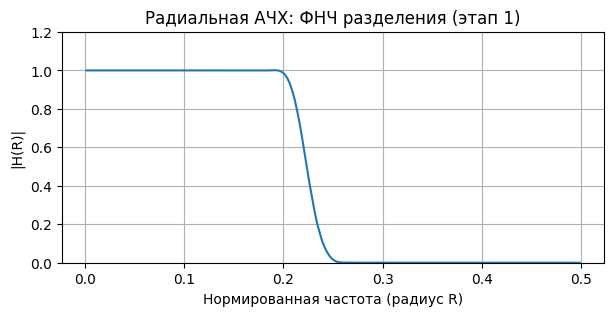

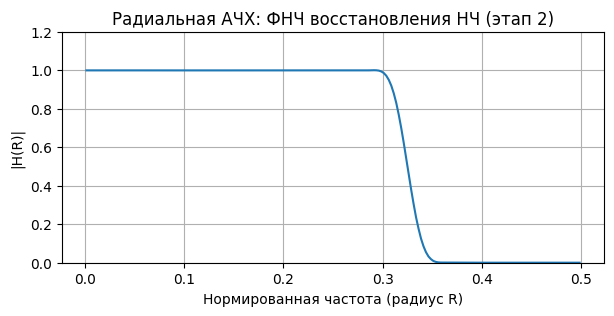

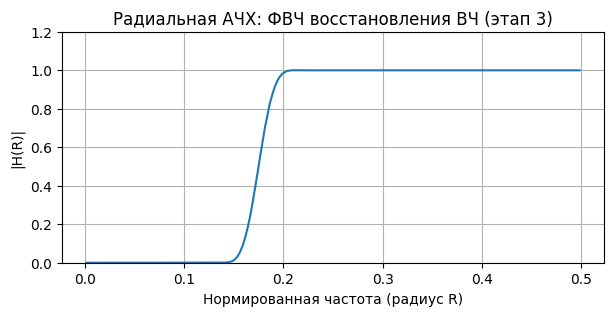


--- Результаты восстановления (N=61, 2D linprog) ---
MSE:  0.00086793
PSNR: 43.81 dB
MAE:  1.508967
Средняя относительная: 100.257 %


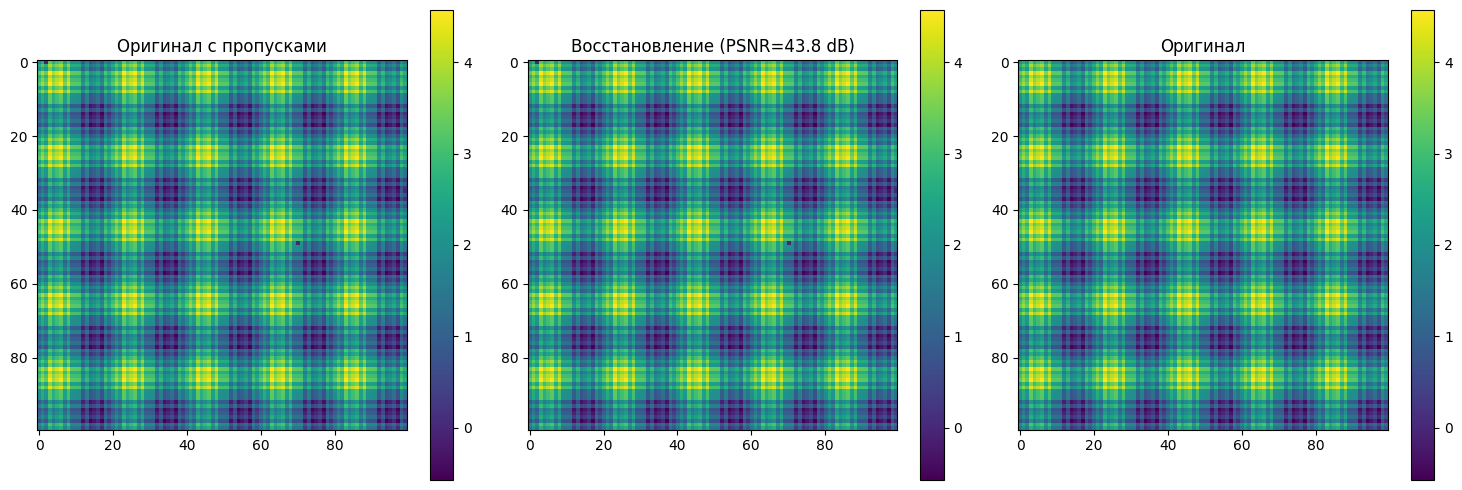

In [ ]:
# ------------------------------------------------------------
# 5. Проверим радиальные АЧХ
# ------------------------------------------------------------

plot_radial(h_sep,      "Радиальная АЧХ: ФНЧ разделения (этап 1)")
plot_radial(h_lp_rest,  "Радиальная АЧХ: ФНЧ восстановления НЧ (этап 2)")
plot_radial(h_hp_rest,  "Радиальная АЧХ: ФВЧ восстановления ВЧ (этап 3)")

# ------------------------------------------------------------
# 6. ЭТАПЫ АЛГОРИТМА ВОССТАНОВЛЕНИЯ
# ------------------------------------------------------------

# Этап 1: разделение
low_sep_missing  = convolve2d(data_missing, h_sep, mode='same', boundary='wrap')
high_sep_missing = data_missing - low_sep_missing

# Этап 2: восстановление НЧ по формуле (3) только в пропусках
low_rest = recover_component_local(low_sep_missing, h_lp_rest, mask_missing)

# Этап 3: восстановление ВЧ по формуле (3) только в пропусках
high_rest = recover_component_local(high_sep_missing, h_hp_rest, mask_missing)

# Этап 4: сумма
proposed = low_rest + high_rest
recovered_values = proposed[mask_missing]

# ------------------------------------------------------------
# 7. Метрики и визуализация
# ------------------------------------------------------------

current_recon = data_missing.copy()
current_recon[mask_missing] = recovered_values

mse = np.mean((current_recon - data_orig)**2)
psnr = 10 * np.log10(np.max(data_orig)**2 / mse)
mae = np.mean(np.abs(recovered_values - true_values))
mre = np.mean(np.abs(recovered_values - true_values) /
              (np.abs(true_values) + 1e-9)) * 100

print("\n--- Результаты восстановления (N=61, 2D linprog) ---")
print(f"MSE:  {mse:.8f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"MAE:  {mae:.6f}")
print(f"Средняя относительная: {mre:.3f} %")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Оригинал с пропусками"); plt.imshow(data_missing, cmap='viridis'); plt.colorbar()
plt.subplot(1,3,2); plt.title(f"Восстановление (PSNR={psnr:.1f} dB)"); plt.imshow(current_recon, cmap='viridis'); plt.colorbar()
plt.subplot(1,3,3); plt.title("Оригинал"); plt.imshow(data_orig, cmap='viridis'); plt.colorbar()
plt.tight_layout()
plt.show()


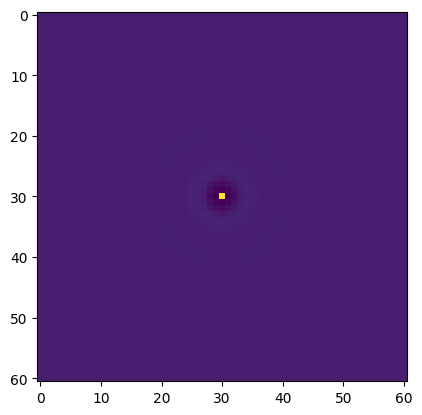

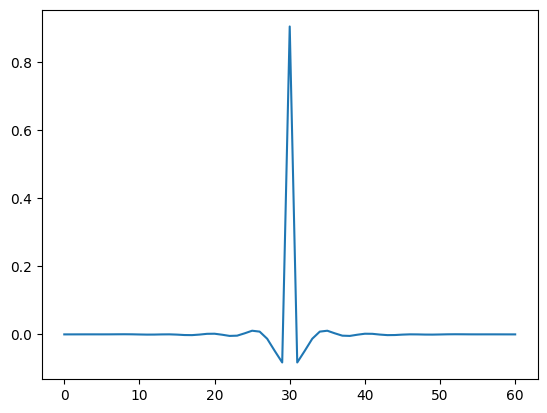

In [ ]:
plt.imshow(h_hp_rest)
plt.show()
plt.plot(h_hp_rest[30])

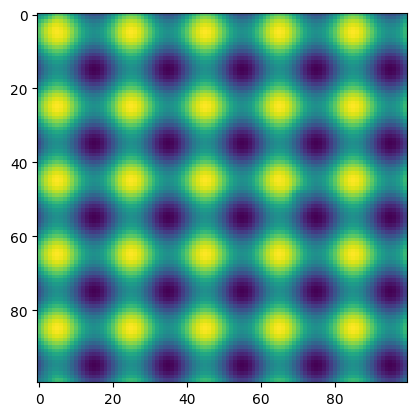

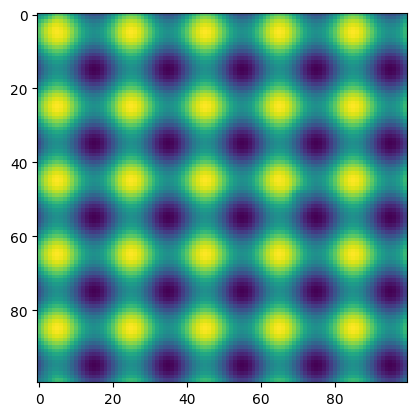

In [ ]:
plt.imshow(low_sep_missing)
plt.show()
plt.imshow(low_rest)

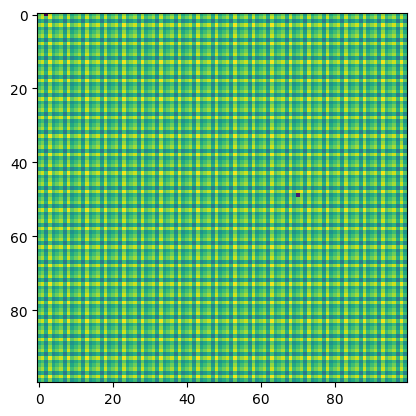

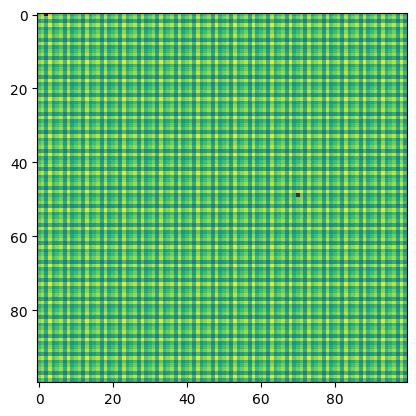

In [ ]:
plt.imshow(high_sep_missing)
plt.show()
plt.imshow(high_rest)

прост


LPF: δ ≈ 0.0176

--- Результаты (только НЧ, 2D-ФНЧ + формула (3)) ---
MSE:  0.00000175
PSNR: 69.61 dB
MAE:  0.014858


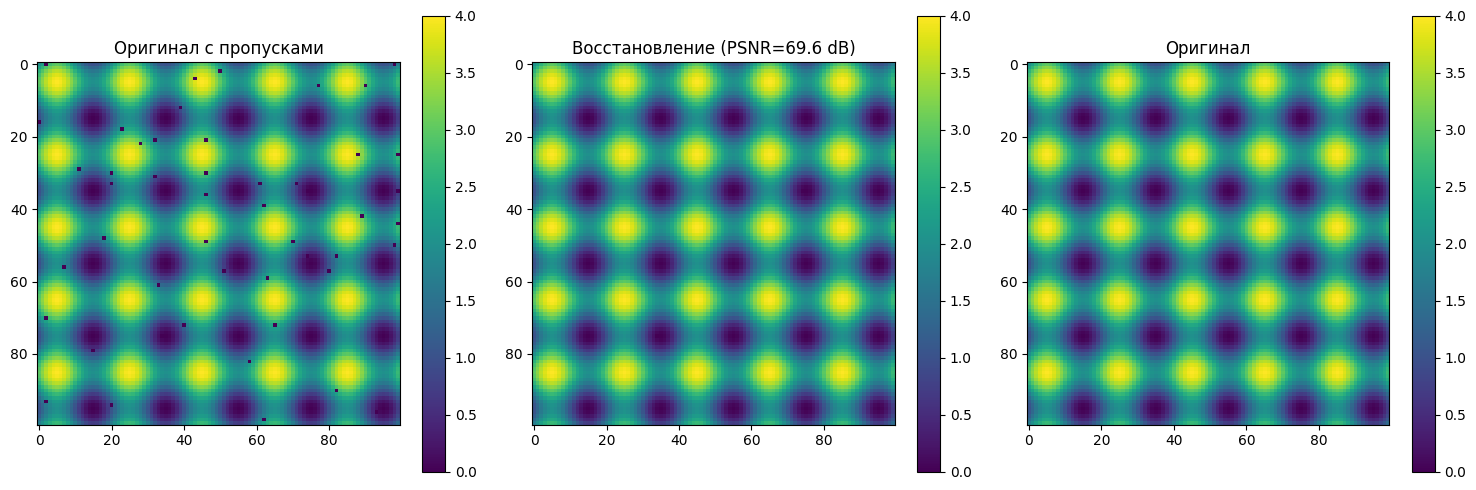

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# ---------- 1. 2D ФНЧ через linprog (как у тебя) ----------

def design_lp_filter_2d(N, cutoff, transition, G=81):
    assert N % 2 == 1
    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R <= cutoff
    stop_mask = R >= cutoff + transition

    coords = np.array([(i - N // 2, j - N // 2)
                       for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(-2j * np.pi *
                                       (du * coords[:, 0] + dv * coords[:, 1]))))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1)
    c[-1] = 1.0

    A_eq = np.zeros((1, M + 1))
    A_eq[0, :M] = 1.0
    b_eq = np.array([1.0])  # Σ h = 1 -> H(0)=1

    A_ub, b_ub = [], []
    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]
    res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # симметрия (нулевая фаза)
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4.0
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]

# ---------- 2. Восстановление по (3) в 2D -----------------

def recover_component_local(data_band, h, mask_missing):
    H, W = data_band.shape
    N = h.shape[0]
    M = N // 2
    h0 = h[M, M]
    denom = 1.0 - h0

    restored = data_band.copy()
    miss_idx = np.argwhere(mask_missing)

    for i0, j0 in miss_idx:
        s = 0.0
        for di in range(-M, M+1):
            for dj in range(-M, M+1):
                if di == 0 and dj == 0:
                    continue
                ii = (i0 - di) % H
                jj = (j0 - dj) % W
                s += h[M+di, M+dj] * data_band[ii, jj]
        restored[i0, j0] = s / denom

    return restored

# ---------- 3. Тест: только НЧ-сигнал ----------------------

o_x = o_y = 100
w_low = 0.05

X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y), indexing="xy")
data_low = 2 + np.sin(2*np.pi*w_low*X) + np.sin(2*np.pi*w_low*Y)
data_orig = data_low.copy()   # только НЧ, без ВЧ

# Пропуски
np.random.seed(1)
mask_missing = np.random.rand(o_x, o_y) < 0.005   # 0.5 % пропусков
data_missing = data_orig.copy()
data_missing[mask_missing] = 0.0

true_values = data_orig[mask_missing]

# ---------- 4. Синтез одного 2D-ФНЧ ------------------------

N_filt = 31   # или 41, 61
cutoff = 0.15   # > w_low=0.05, но далеко от 0.5
transition = 0.05
h_lp, delta = design_lp_filter_2d(N_filt, cutoff, transition, G=81)
print(f"LPF: δ ≈ {delta:.4f}")

# ---------- 5. Восстановление НЧ-только --------------------

low_rest = recover_component_local(data_missing, h_lp, mask_missing)

current_recon = data_missing.copy()
current_recon[mask_missing] = low_rest[mask_missing]

mse = np.mean((current_recon - data_orig)**2)
psnr = 10 * np.log10(np.max(data_orig)**2 / mse)
mae = np.mean(np.abs(low_rest[mask_missing] - true_values))

print("\n--- Результаты (только НЧ, 2D-ФНЧ + формула (3)) ---")
print(f"MSE:  {mse:.8f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"MAE:  {mae:.6f}")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Оригинал с пропусками"); plt.imshow(data_missing, cmap='viridis'); plt.colorbar()
plt.subplot(1,3,2); plt.title(f"Восстановление (PSNR={psnr:.1f} dB)"); plt.imshow(current_recon, cmap='viridis'); plt.colorbar()
plt.subplot(1,3,3); plt.title("Оригинал"); plt.imshow(data_orig, cmap='viridis'); plt.colorbar()
plt.tight_layout()
plt.show()


Всего дырок: 7
ФНЧ для построения ФВЧ: δ ≈ 0.0170
Центральный коэффициент ФВЧ h0_hp = 0.9133354273600244 , 1-h0_hp = 0.08666457263997562

--- Ошибки только в дырках ---
MAE (средняя абсолютная ошибка): 0.43033677994865155
Max |err|: 1.1319094068672066


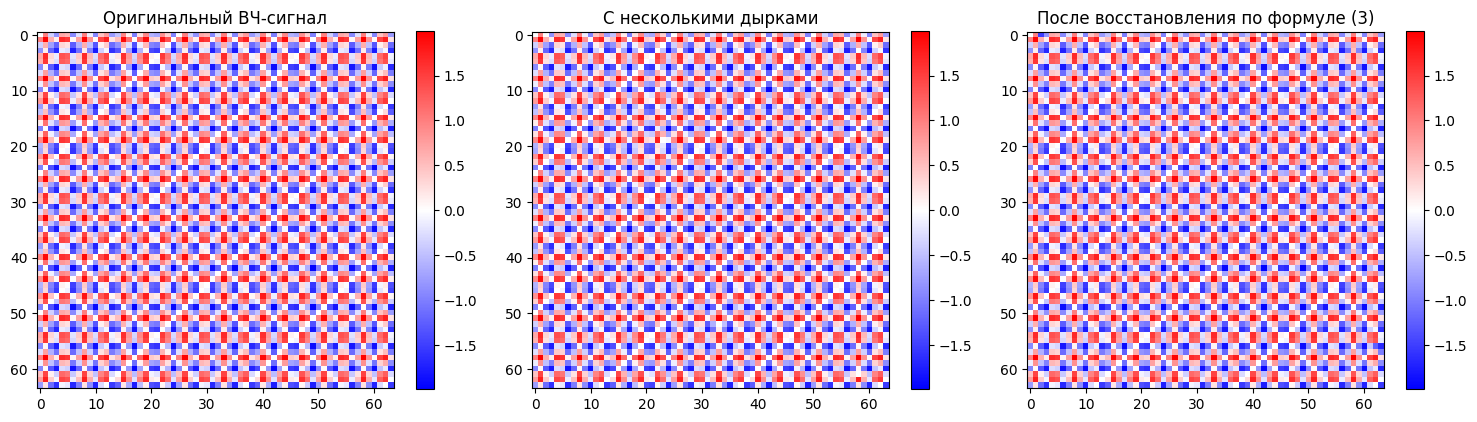

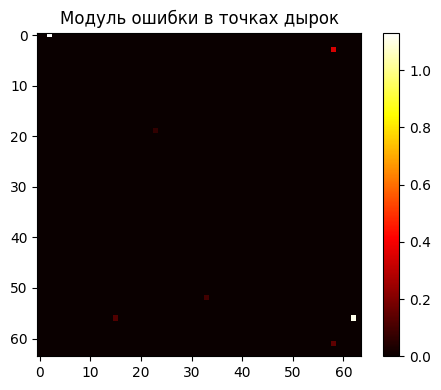

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def design_lp_filter_2d(N, cutoff, transition, G=81):
    """
    2D КИХ-ФНЧ методом линейного программирования (Chebyshev).
    Нормированная частота по радиусу R ∈ [0, 0.5].

    passband: R <= cutoff
    stopband: R >= cutoff + transition
    """
    assert N % 2 == 1, "N должно быть нечётным"
    # сетка частот
    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R <= cutoff
    stop_mask = R >= cutoff + transition

    # координаты импульсной характеристики
    coords = np.array([(i - N // 2, j - N // 2)
                       for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(
                -2j * np.pi * (du * coords[:, 0] + dv * coords[:, 1])
            )))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1)
    c[-1] = 1.0        # минимизируем δ

    # H(0) = 1  => сумма коэффициентов = 1
    A_eq = np.zeros((1, M + 1))
    A_eq[0, :M] = 1.0
    b_eq = np.array([1.0])

    A_ub, b_ub = [], []

    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]

    res = linprog(c, A_ub, b_ub, A_eq, b_eq,
                  bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # симметрия (нулевая фаза)
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4.0
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]

# --- 1. ПАРАМЕТРЫ СИГНАЛА (ЧИСТО ВЧ) ---------------------------------

o_x = o_y = 64
w_high = 0.28   # ВЧ-частота, под которую мы подбирали фильтр

X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y), indexing="xy")
v_high = np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y)

# --- 2. НЕСКОЛЬКО ДЫРОК ----------------------------------------------

np.random.seed(1)
p_holes = 0.001          # ~0.1% пропусков, чтобы в окне редко было >1 дыры
mask_missing = np.random.rand(o_x, o_y) < p_holes

v_missing = v_high.copy()
v_missing[mask_missing] = 0.0

true_values = v_high[mask_missing]

print("Всего дырок:", mask_missing.sum())

# --- 3. СИНТЕЗ LPF И ПОСТРОЕНИЕ HPF ЧЕРЕЗ ТВОЙ МЕТОД -----------------

N_filt = 31
cutoff_lp_for_hp = 0.14   # LPF гасит низкие, HPF = I - LPF пропускает выше
transition = 0.05

h_lp_for_hp, delta = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_lp_for_hp,
    transition=transition,
    G=81
)
print(f"ФНЧ для построения ФВЧ: δ ≈ {delta:.4f}")

I_imp = np.zeros_like(h_lp_for_hp)
I_imp[N_filt//2, N_filt//2] = 1.0
h_hp = I_imp - h_lp_for_hp

h0_hp = h_hp[N_filt//2, N_filt//2]
print("Центральный коэффициент ФВЧ h0_hp =", h0_hp, ", 1-h0_hp =", 1 - h0_hp)

# --- 4. ВОССТАНОВЛЕНИЕ ВСЕХ ДЫРОК ПО ФОРМУЛЕ (3) ---------------------

v_rec = recover_component_local(v_missing, h_hp, mask_missing)

recovered_values = v_rec[mask_missing]

abs_errors = np.abs(recovered_values - true_values)
mae = abs_errors.mean()
max_err = abs_errors.max()

print("\n--- Ошибки только в дырках ---")
print("MAE (средняя абсолютная ошибка):", mae)
print("Max |err|:", max_err)

# --- 5. ВИЗУАЛИЗАЦИЯ -------------------------------------------------

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Оригинальный ВЧ-сигнал")
plt.imshow(v_high, cmap="bwr")
plt.colorbar()

plt.subplot(1,3,2)
plt.title("С несколькими дырками")
plt.imshow(v_missing, cmap="bwr")
plt.colorbar()

plt.subplot(1,3,3)
plt.title("После восстановления по формуле (3)")
plt.imshow(v_rec, cmap="bwr")
plt.colorbar()

plt.tight_layout()
plt.show()

# Дополнительно: карта ошибок только в дырках
err_map = np.zeros_like(v_high)
err_map[mask_missing] = abs_errors

plt.figure(figsize=(5,4))
plt.title("Модуль ошибки в точках дырок")
plt.imshow(err_map, cmap="hot")
plt.colorbar()
plt.tight_layout()
plt.show()


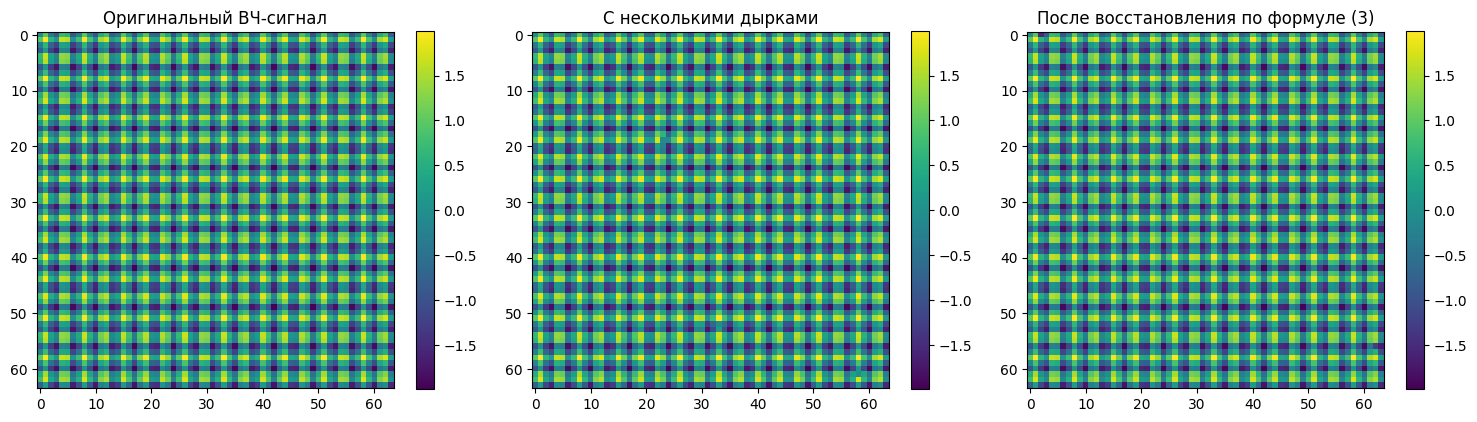

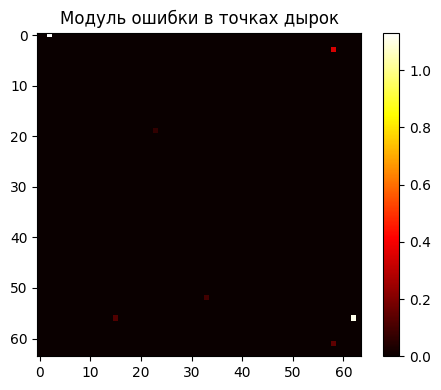

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Оригинальный ВЧ-сигнал")
plt.imshow(v_high)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("С несколькими дырками")
plt.imshow(v_missing)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("После восстановления по формуле (3)")
plt.imshow(v_rec)
plt.colorbar()

plt.tight_layout()
plt.show()

# Дополнительно: карта ошибок только в дырках
err_map = np.zeros_like(v_high)
err_map[mask_missing] = abs_errors

plt.figure(figsize=(5,4))
plt.title("Модуль ошибки в точках дырок")
plt.imshow(err_map, cmap="hot")
plt.colorbar()
plt.tight_layout()
plt.show()

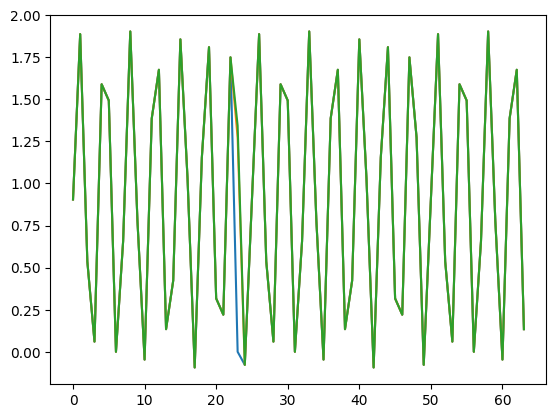

In [ ]:
plt.plot(v_missing[19])
plt.plot(v_high[19])
plt.plot(v_rec[19])

Синтез ФНЧ-разделителя...
δ разделяющего фильтра ≈ 0.0498

--- Качество разделения ---
MSE (НЧ):   0.00007282
PSNR (НЧ):  53.42 dB
MSE (ВЧ):   0.00007282
PSNR (ВЧ):  40.94 dB


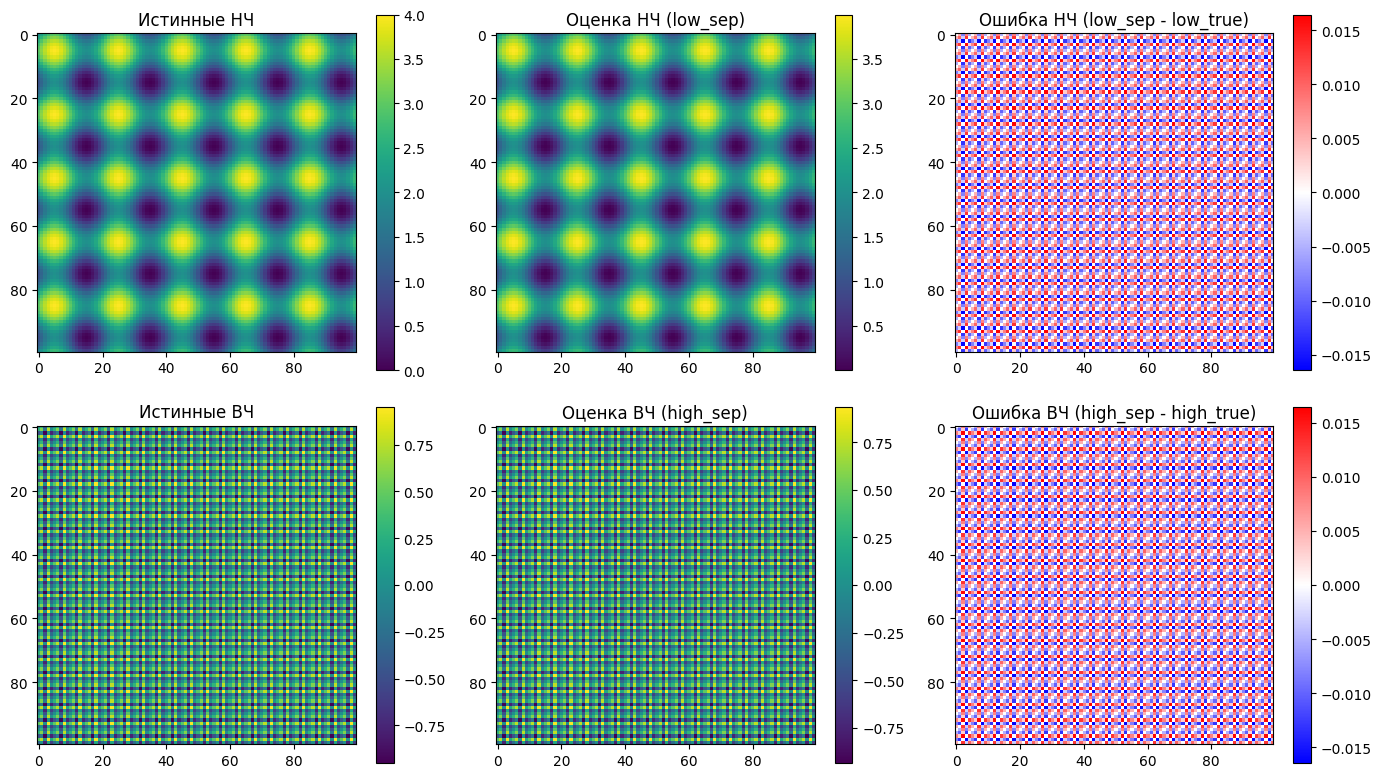

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.optimize import linprog

# ------------- твоя функция синтеза 2D ФНЧ -----------------

def design_lp_filter_2d(N, cutoff, transition, G=81):
    """
    2D КИХ-ФНЧ методом линейного программирования (Chebyshev).
    Нормированная частота по радиусу R ∈ [0, 0.5].

    passband: R <= cutoff
    stopband: R >= cutoff + transition
    """
    assert N % 2 == 1, "N должно быть нечётным"
    # сетка частот
    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R <= cutoff
    stop_mask = R >= cutoff + transition

    # координаты импульсной характеристики
    coords = np.array([(i - N // 2, j - N // 2)
                       for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(
                -2j * np.pi * (du * coords[:, 0] + dv * coords[:, 1])
            )))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1)
    c[-1] = 1.0        # минимизируем δ

    # H(0) = 1  => сумма коэффициентов = 1
    A_eq = np.zeros((1, M + 1))
    A_eq[0, :M] = 1.0
    b_eq = np.array([1.0])

    A_ub, b_ub = [], []

    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]

    res = linprog(c, A_ub, b_ub, A_eq, b_eq,
                  bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # симметрия (нулевая фаза)
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4.0
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]


# ------------- 1. Генерим НЧ + ВЧ без дырок ----------------

o_x = o_y = 100
w_low  = 0.05
w_high = 0.40

X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y), indexing="xy")

low_true  = 2 + np.sin(2*np.pi*w_low*X) + np.sin(2*np.pi*w_low*Y)
high_true = 0.5 * (np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y))
data      = low_true + high_true


# ------------- 2. Синтезуем ФНЧ для разделения --------------

N_filt = 21
cutoff_sep    = 0.3
transition_sep = 0.05

print("Синтез ФНЧ-разделителя...")
h_sep, delta_sep = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_sep,
    transition=transition_sep,
    G=81
)
print(f"δ разделяющего фильтра ≈ {delta_sep:.4f}")

# ------------- 3. Разделяем сигнал --------------------------

low_sep  = convolve2d(data, h_sep, mode='same', boundary='wrap')
high_sep = data - low_sep

# ------------- 4. Оцениваем качество разделения ------------

mse_low  = np.mean((low_sep  - low_true)**2)
mse_high = np.mean((high_sep - high_true)**2)

psnr_low  = 10 * np.log10(np.max(low_true)**2  / mse_low)
psnr_high = 10 * np.log10(np.max(high_true)**2 / mse_high)

print("\n--- Качество разделения ---")
print(f"MSE (НЧ):   {mse_low:.8f}")
print(f"PSNR (НЧ):  {psnr_low:.2f} dB")
print(f"MSE (ВЧ):   {mse_high:.8f}")
print(f"PSNR (ВЧ):  {psnr_high:.2f} dB")

# ------------- 5. Визуализация ------------------------------

plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.title("Истинные НЧ")
plt.imshow(low_true, cmap='viridis'); plt.colorbar()

plt.subplot(2,3,2)
plt.title("Оценка НЧ (low_sep)")
plt.imshow(low_sep, cmap='viridis'); plt.colorbar()

plt.subplot(2,3,3)
plt.title("Ошибка НЧ (low_sep - low_true)")
plt.imshow(low_sep - low_true, cmap='bwr'); plt.colorbar()

plt.subplot(2,3,4)
plt.title("Истинные ВЧ")
plt.imshow(high_true, cmap='viridis'); plt.colorbar()

plt.subplot(2,3,5)
plt.title("Оценка ВЧ (high_sep)")
plt.imshow(high_sep, cmap='viridis'); plt.colorbar()

plt.subplot(2,3,6)
plt.title("Ошибка ВЧ (high_sep - high_true)")
plt.imshow(high_sep - high_true, cmap='bwr'); plt.colorbar()

plt.tight_layout()
plt.show()


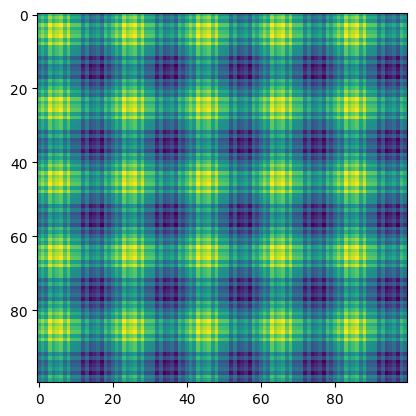

In [ ]:
plt.imshow(data)

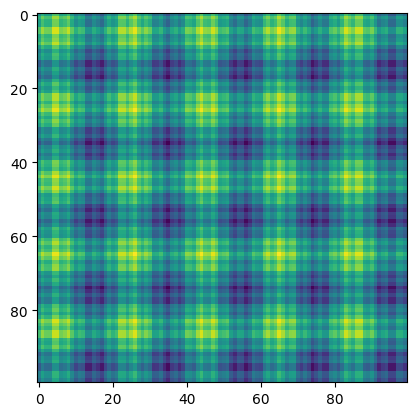

In [ ]:
plt.imshow(data)

финал(возможно)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.signal import convolve2d

# ---------- 1. Синтез 2D ФНЧ -----------------

def design_lp_filter_2d(N, cutoff, transition, G=81):
    assert N % 2 == 1, "N должно быть нечётным"

    u = (np.arange(G) - G // 2) / G
    U, V = np.meshgrid(u, u, indexing="ij")
    R = np.sqrt(U**2 + V**2)

    pass_mask = R <= cutoff
    stop_mask = R >= cutoff + transition

    coords = np.array([(i - N // 2, j - N // 2)
                       for i in range(N) for j in range(N)])

    def build_A(mask):
        rows = []
        idx = np.where(mask)
        for k, l in zip(idx[0], idx[1]):
            du, dv = U[k, l], V[k, l]
            rows.append(np.real(np.exp(
                -2j * np.pi * (du * coords[:, 0] + dv * coords[:, 1])
            )))
        return np.asarray(rows)

    A_pass = build_A(pass_mask)
    A_stop = build_A(stop_mask)

    M = N * N
    c = np.zeros(M + 1); c[-1] = 1.0

    A_eq = np.zeros((1, M + 1))
    A_eq[0, :M] = 1.0
    b_eq = np.array([1.0])

    A_ub, b_ub = [], []

    # passband: 1-δ ≤ H ≤ 1+δ
    A_ub += [np.hstack([ A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [ np.ones(A_pass.shape[0]) ]
    A_ub += [np.hstack([-A_pass, -np.ones((A_pass.shape[0], 1)) ])]
    b_ub += [-np.ones(A_pass.shape[0])]

    # stopband: |H| ≤ δ
    A_ub += [np.hstack([ A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]
    A_ub += [np.hstack([-A_stop, -np.ones((A_stop.shape[0], 1)) ])]
    b_ub += [ np.zeros(A_stop.shape[0]) ]

    A_ub = np.vstack(A_ub)
    b_ub = np.hstack(b_ub)

    bounds = [(-1, 1)] * M + [(0, None)]

    res = linprog(c, A_ub, b_ub, A_eq, b_eq,
                  bounds=bounds, method="highs")

    h = res.x[:M].reshape(N, N)

    # симметрия (нулевая фаза)
    for i in range(N):
        for j in range(N):
            i2, j2 = N - 1 - i, N - 1 - j
            mean = (h[i, j] + h[i2, j] + h[i, j2] + h[i2, j2]) / 4.0
            h[i, j] = h[i2, j] = h[i, j2] = h[i2, j2] = mean

    return h, res.x[-1]


# ---------- 2. Восстановление по формуле (3) в 2D --------

def recover_component_local(data_band, h, mask_missing):
    H, W = data_band.shape
    N = h.shape[0]
    M = N // 2
    h0 = h[M, M]
    denom = 1.0 - h0

    restored = data_band.copy()
    miss_idx = np.argwhere(mask_missing)

    for i0, j0 in miss_idx:
        s = 0.0
        for di in range(-M, M+1):
            for dj in range(-M, M+1):
                if di == 0 and dj == 0:
                    continue
                ii = (i0 - di) % H
                jj = (j0 - dj) % W
                s += h[M+di, M+dj] * data_band[ii, jj]
        restored[i0, j0] = s / denom

    return restored


# ---------- 3. Грубое начальное заполнение дырок ---------

def naive_fill(data, mask_missing, iters=5):
    filled = data.copy()
    H, W = data.shape

    kernel = np.ones((3,3)) / 9.0

    for _ in range(iters):
        # среднее по окрестности
        local_mean = convolve2d(filled, kernel, mode='same', boundary='wrap')
        # обновляем только дырки
        filled[mask_missing] = local_mean[mask_missing]

    return filled


**Тест**

In [ ]:
# ---------- 4. Тестовый сигнал НЧ+ВЧ с пропусками ---------

o_x = o_y = 64
w_low  = 0.05
w_high = 0.28

X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y), indexing="xy")

data_low  = 2 + np.sin(2*np.pi*w_low*X)  + np.sin(2*np.pi*w_low*Y)
data_high = np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y)
data_orig = data_low + data_high

In [ ]:
N_filt = 21

# a) ФНЧ для разделения
cutoff_sep     = 0.15
transition_sep = 0.05

h_sep, delta_sep = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_sep,
    transition=transition_sep,
    G=81
)
print(f"ФНЧ разделения: δ ≈ {delta_sep:.4f}")

ФНЧ разделения: δ ≈ 0.0494


In [ ]:
# ---------- 6. Разделение предварительно заполненного сигнала -----

low_sep_init  = convolve2d(data_orig, h_sep, mode='same', boundary='wrap')
high_sep_init = data_orig - low_sep_init

# "дырявые" версии для восстановления (дырки = 0)
low_sep_missing  = low_sep_init.copy()
high_sep_missing = high_sep_init.copy()

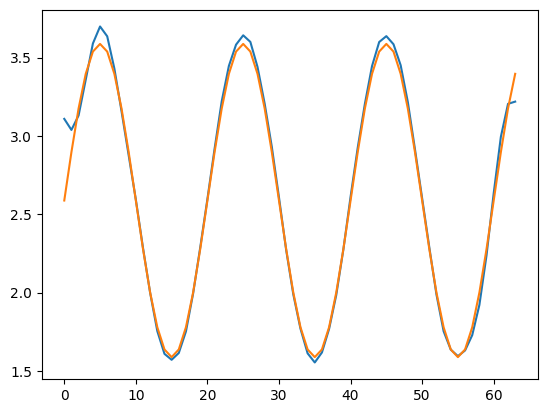

In [ ]:
plt.plot(low_sep_missing[42])
plt.plot(data_low[42])

In [ ]:
np.random.seed(1)
mask_missing = np.random.rand(o_x, o_y) < 0.002   # % дырок

data_missing_low = low_sep_init.copy()
data_missing_low[mask_missing] = 0.0

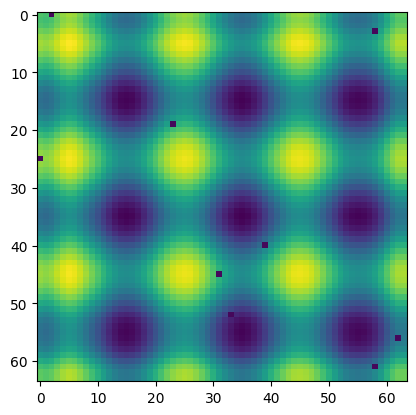

In [ ]:
plt.imshow(data_missing_low)

In [ ]:
# б) ФНЧ восстановления НЧ (шире)
cutoff_lp_rest   = 0.25
transition_rest  = 0.05

h_lp_rest, delta_lp = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_lp_rest,
    transition=transition_rest,
    G=81
)
print(f"ФНЧ восстановления НЧ: δ ≈ {delta_lp:.4f}")

ФНЧ восстановления НЧ: δ ≈ 0.0550


In [ ]:
low_rest  = recover_component_local(data_missing_low,  h_lp_rest,  mask_missing)

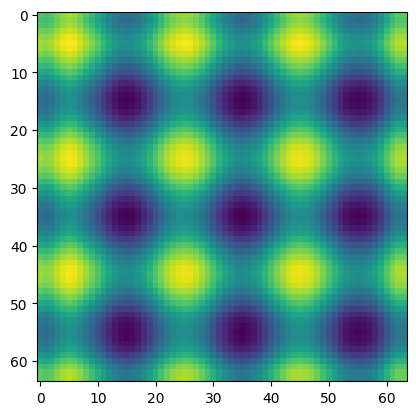

In [ ]:
plt.imshow(low_rest)

In [ ]:
data_missing_high = high_sep_init.copy()
data_missing_high[mask_missing] = 0.0

In [ ]:
# в) ФНЧ для построения ФВЧ (граница ниже, чем у разделяющего)
cutoff_lp_for_hp = 0.1

h_lp_for_hp, delta_lp2 = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_lp_for_hp,
    transition=transition_rest,
    G=81
)
print(f"ФНЧ для построения ФВЧ: δ ≈ {delta_lp2:.4f}")

I_imp = np.zeros_like(h_lp_for_hp)
I_imp[N_filt//2, N_filt//2] = 1.0
h_hp_rest = I_imp - h_lp_for_hp

ФНЧ для построения ФВЧ: δ ≈ 0.0541


In [ ]:
high_rest = recover_component_local(data_missing_high, h_hp_rest,  mask_missing)

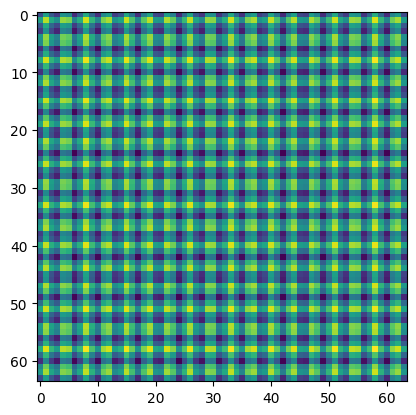

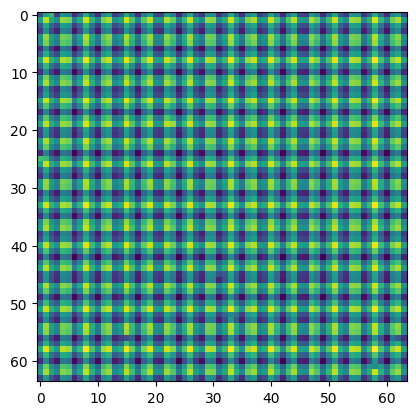

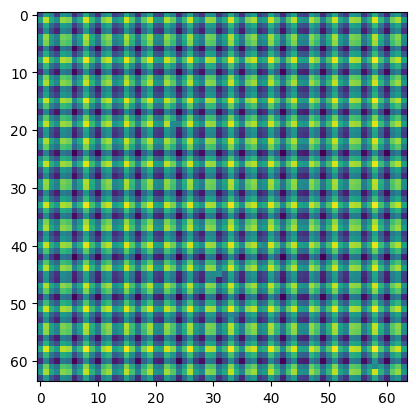

In [ ]:
plt.imshow(high_sep_init)
plt.show()
plt.imshow(high_rest)
plt.show()
plt.imshow(data_missing_high)

In [ ]:
fin = high_rest + low_rest

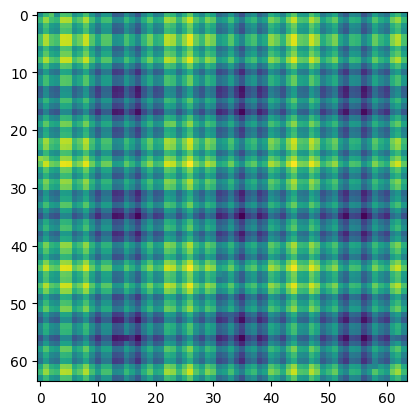

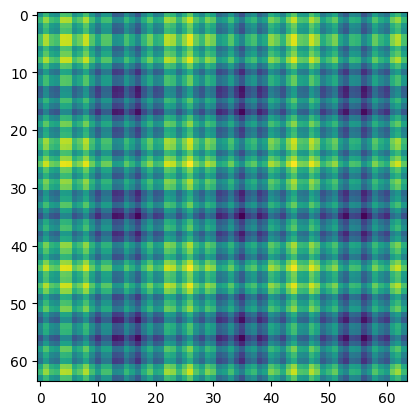

In [ ]:
plt.imshow(fin)
plt.show()
plt.imshow(data_orig)

**Тест(конец)**

In [ ]:
# ---------- 4. Тестовый сигнал НЧ+ВЧ с пропусками ---------

o_x = o_y = 64
w_low  = 0.05
w_high = 0.28

X, Y = np.meshgrid(np.arange(o_x), np.arange(o_y), indexing="xy")

data_low  = 2 + np.sin(2*np.pi*w_low*X)  + np.sin(2*np.pi*w_low*Y)
data_high = np.sin(2*np.pi*w_high*X) + np.sin(2*np.pi*w_high*Y)
data_orig = data_low + data_high

mask_missing = np.random.rand(o_x, o_y) < 0.0002   # % дырок


In [ ]:
mask_missing[30][20] = np.True_

In [ ]:
mask_missing[30][17] = np.False_

In [ ]:
data_missing = data_orig.copy()
data_missing[mask_missing] = 0.0
true_values = data_orig[mask_missing]

mask_valid = (~mask_missing).astype(float)
# --- начальная грубая заливка дырок ---
#data_init = naive_fill(data_missing, mask_missing, iters=8)
data_init = data_missing

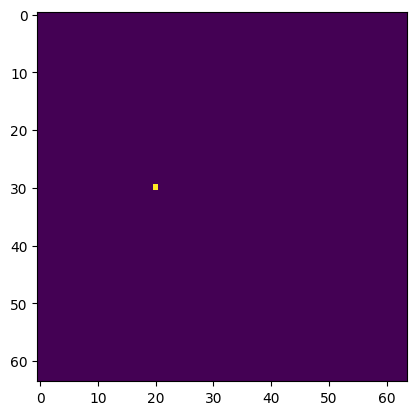

In [ ]:
plt.imshow(mask_missing)

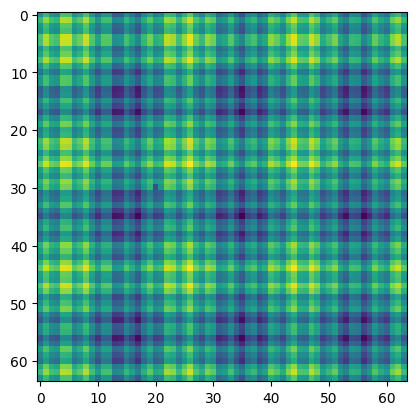

In [ ]:
plt.imshow(data_init)

In [ ]:
# ---------- 5. Синтез 2D-фильтров -------------------------
N_filt = 21

# a) ФНЧ для разделения
cutoff_sep     = 0.14
transition_sep = 0.05

h_sep, delta_sep = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_sep,
    transition=transition_sep,
    G=81
)
print(f"ФНЧ разделения: δ ≈ {delta_sep:.4f}")


ФНЧ разделения: δ ≈ 0.0518


In [ ]:
from scipy.signal import convolve2d
import numpy as np

def low_high_separation_normalized(data_missing, mask_missing, h_sep):

    mask_valid = (~mask_missing).astype(float)

    num = convolve2d(data_missing, h_sep, mode='same', boundary='wrap')

    denom = convolve2d(mask_valid, h_sep, mode='same', boundary='wrap')

    low_sep = np.zeros_like(num)

    eps = 1e-6
    good = np.abs(denom) > eps
    low_sep[good] = num[good] / denom[good]

    low_sep_raw = convolve2d(data_missing, h_sep, mode='same', boundary='wrap')
    low_sep[~good] = low_sep_raw[~good]

    high_sep = data_missing - low_sep

    return low_sep, high_sep


In [ ]:

low_sep_missing, high_sep_missing = low_high_separation_normalized(
    data_missing,
    mask_missing,
    h_sep
)


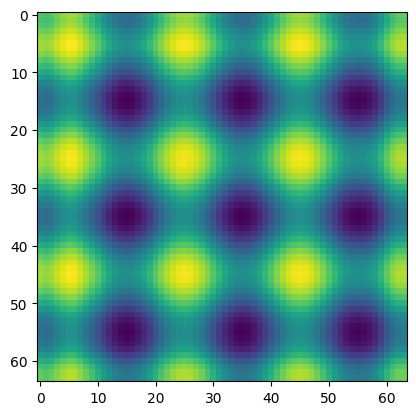

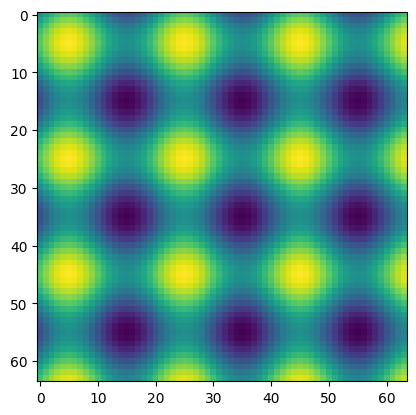

In [ ]:
plt.imshow(low_sep_missing)
plt.show()
plt.imshow(data_low)

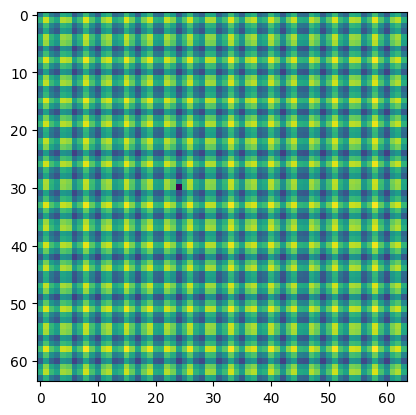

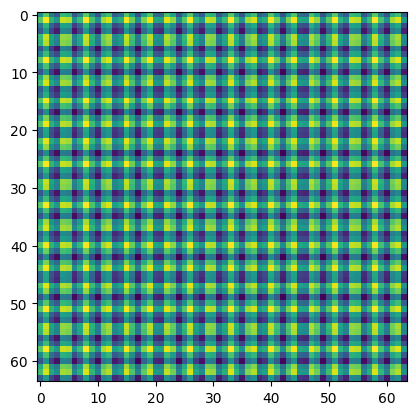

In [ ]:
plt.imshow(high_sep_missing)
plt.show()
plt.imshow(data_high)

In [ ]:
high_sep_missing[19][23]

np.float64(1.241358259049715)

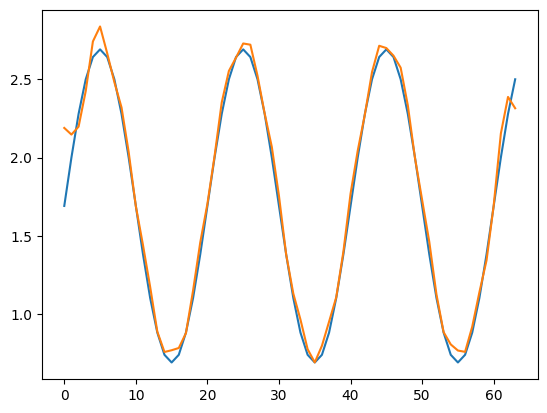

In [ ]:
plt.plot(data_low[19])
plt.plot(low_sep_missing[19])

In [ ]:
# б) ФНЧ восстановления НЧ (шире)
cutoff_lp_rest   = 0.25
transition_rest  = 0.05

h_lp_rest, delta_lp = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_lp_rest,
    transition=transition_rest,
    G=81
)
print(f"ФНЧ восстановления НЧ: δ ≈ {delta_lp:.4f}")

ФНЧ восстановления НЧ: δ ≈ 0.0550


In [ ]:
low_rest  = recover_component_local(low_sep_missing,  h_lp_rest,  mask_missing)

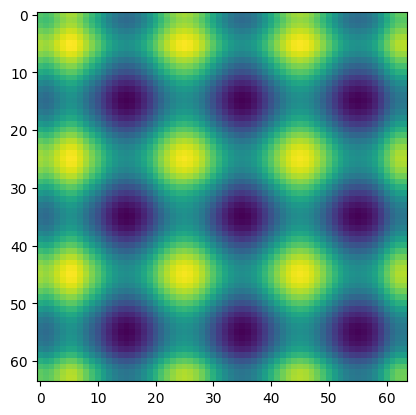

In [ ]:
plt.imshow(low_rest)

**ВЧ**

In [ ]:
# в) ФНЧ для построения ФВЧ (граница ниже, чем у разделяющего)
cutoff_lp_for_hp = 0.1

h_lp_for_hp, delta_lp2 = design_lp_filter_2d(
    N=N_filt,
    cutoff=cutoff_lp_for_hp,
    transition=transition_rest,
    G=81
)
print(f"ФНЧ для построения ФВЧ: δ ≈ {delta_lp2:.4f}")

I_imp = np.zeros_like(h_lp_for_hp)
I_imp[N_filt//2, N_filt//2] = 1.0
h_hp_rest = I_imp - h_lp_for_hp

ФНЧ для построения ФВЧ: δ ≈ 0.0541


In [ ]:
high_rest = recover_component_local(high_sep_missing, h_hp_rest,  mask_missing)

In [ ]:
high_sep_missing[46][31]

np.float64(-1.6500349110253634)

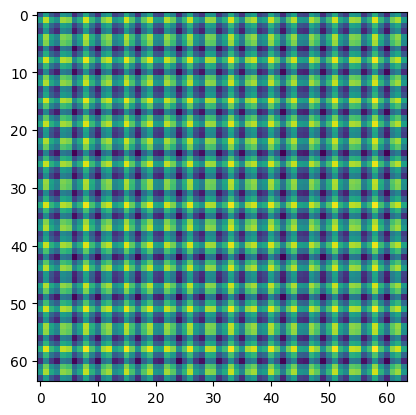

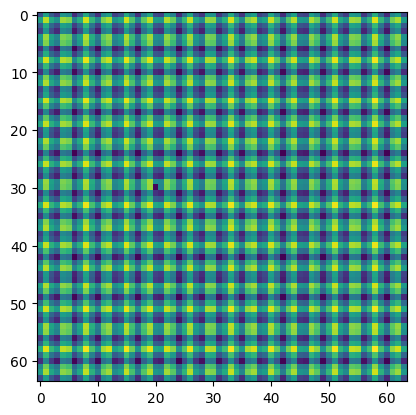

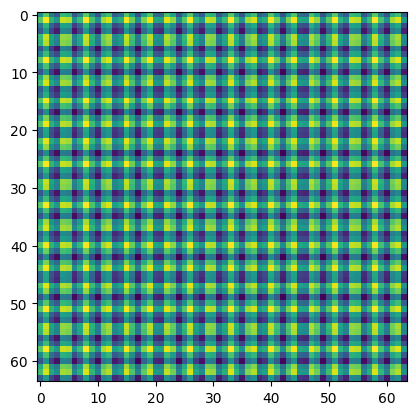

In [ ]:
plt.imshow(high_rest)
plt.show()
plt.imshow(high_sep_missing)
plt.show()
plt.imshow(data_high)

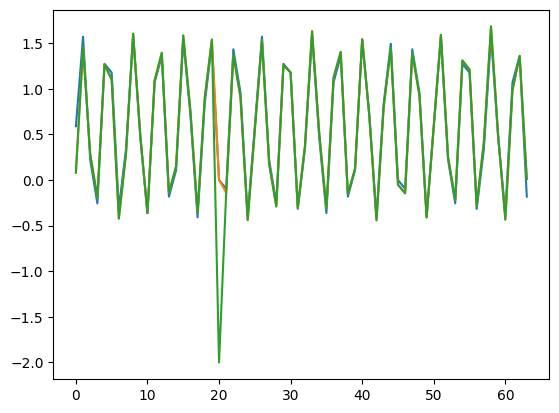

In [ ]:
plt.plot(data_high[30])
plt.plot(high_rest[30])
plt.plot(high_sep_missing[30])

In [ ]:
print(high_rest[23][22])
print(high_sep_missing[23][22])
print(data_high[23][22])

1.328884229505517
-3.3564098423116855
1.212452478186693


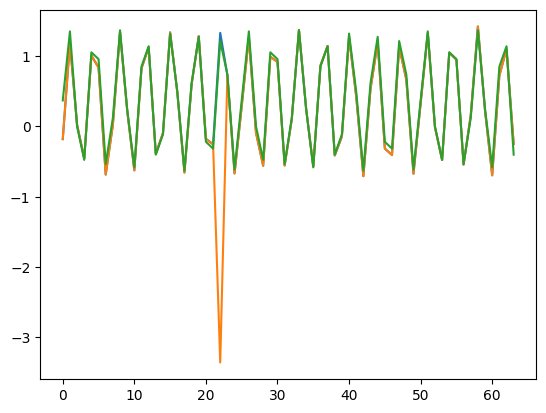

In [ ]:
plt.plot(high_rest[23])
plt.plot(high_sep_missing[23])
plt.plot(data_high[23])

In [ ]:
# Сумма компонентов
proposed = low_rest + high_rest

# Вставляем восстановленные значения только в дырки,
# на остальных пикселях оставляем исходный сигнал без пропусков.
current_recon = data_orig.copy()
current_recon[mask_missing] = proposed[mask_missing]


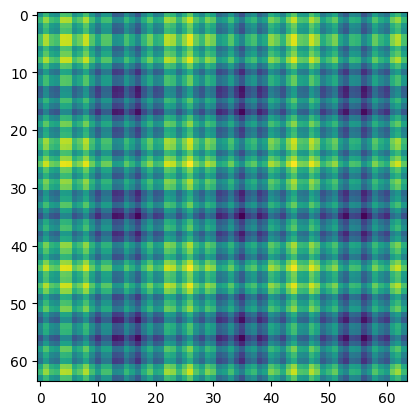

In [ ]:
plt.imshow(current_recon)


--- Полный алгоритм (разделение + восстановление НЧ/ВЧ) ---
MSE  по всей картинке: 0.00000000
PSNR по всей картинке: 203.84 dB
MAE  в точках дырок:   0.000000
Средняя относит. ошибка в дырках: 0.00 %


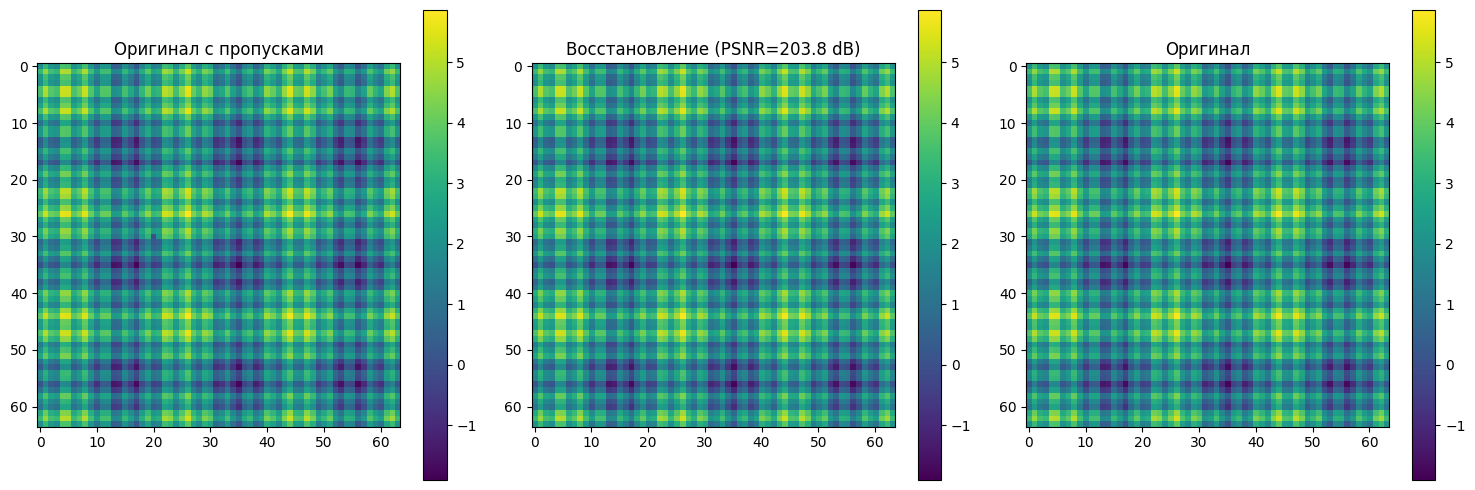

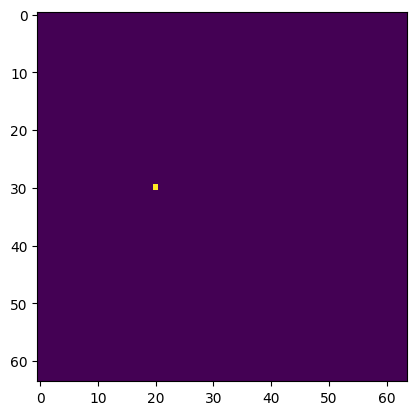

In [ ]:
# ---------- 8. Метрики ---------------------------------------------

mse  = np.mean((current_recon - data_orig)**2)
psnr = 10 * np.log10(np.max(data_orig)**2 / mse)

recovered_values = current_recon[mask_missing]
abs_err = np.abs(recovered_values - true_values)
mae = abs_err.mean()
mre = (abs_err / (np.abs(true_values) + 1e-9)).mean() * 100

print("\n--- Полный алгоритм (разделение + восстановление НЧ/ВЧ) ---")
print(f"MSE  по всей картинке: {mse:.8f}")
print(f"PSNR по всей картинке: {psnr:.2f} dB")
print(f"MAE  в точках дырок:   {mae:.6f}")
print(f"Средняя относит. ошибка в дырках: {mre:.2f} %")

# ---------- 9. Картинки --------------------------------------------

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Оригинал с пропусками")
plt.imshow(data_missing, cmap='viridis'); plt.colorbar()

plt.subplot(1,3,2); plt.title(f"Восстановление (PSNR={psnr:.1f} dB)")
plt.imshow(current_recon, cmap='viridis'); plt.colorbar()

plt.subplot(1,3,3); plt.title("Оригинал")
plt.imshow(data_orig, cmap='viridis'); plt.colorbar()

plt.tight_layout()
plt.show()

plt.imshow(mask_missing)


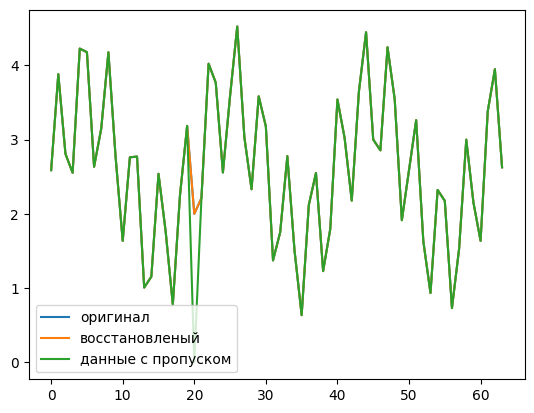

In [ ]:
plt.plot(data_orig[30], label='оригинал')
plt.plot(current_recon[30], label='восстановленый')
plt.plot(data_missing[30], label='данные с пропуском')
plt.legend()
plt.show()

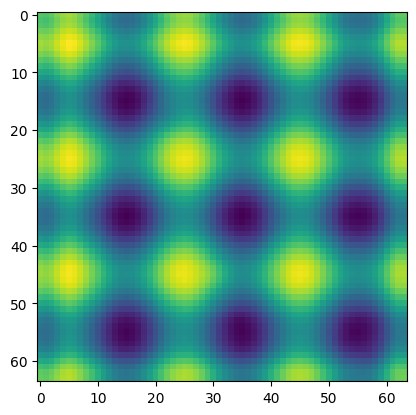

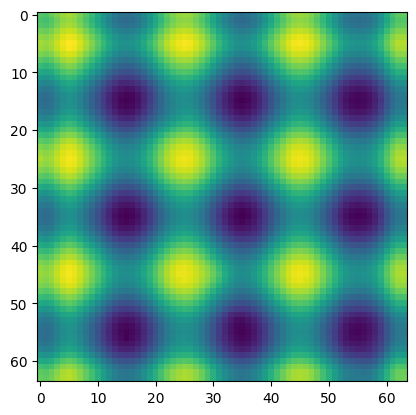

In [ ]:
plt.imshow(low_sep_missing)
plt.show()
plt.imshow(low_rest)

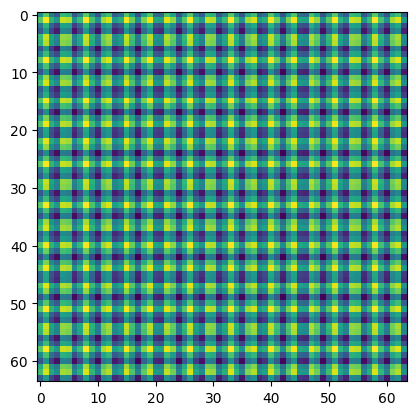

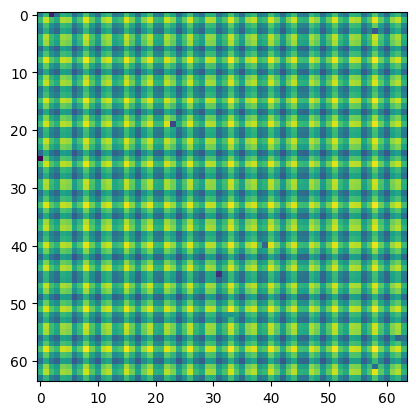

In [ ]:
plt.imshow(data_high)
plt.show()
plt.imshow(high_sep_missing)